# Figure 1~4

In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib as mpl

from matplotlib.patches import Rectangle, FancyArrowPatch

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300

# -------------------------
# Config
# -------------------------
EXCEL_PATH = r"../Soil quality data/Soil quality data 2025.xlsx"
SHEET_NAME = "PHChemical"

PROTECTED_GPKG = "../data_hmq/Map/abu_dhabi_protected_areas.gpkg"
PROTECTED_LAYER = "Protected_Areas"

ABU_DHABI_SHP = r"../data_hmq/Map/abu_dhabi.shp"
BASEMAP = cx.providers.Esri.WorldGrayCanvas

OUT_DIR = r"../Result_hmq/Ch04_Figures"
os.makedirs(OUT_DIR, exist_ok=True)

In [6]:
def add_north_arrow(ax, x=0.05, y=0.86, dy=0.07):
    arrow = FancyArrowPatch(
        (x, y), (x, y + dy),
        transform=ax.transAxes,
        arrowstyle="-|>",
        linewidth=1.2,
        color="black",
        zorder=30
    )
    ax.add_patch(arrow)
    ax.text(
        x, y + dy + 0.01, "N",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10, zorder=30
    )

def add_scale_bar(ax, xmin, ymin, xmax, ymax, length_km=200):
    length_m = length_km * 1000
    x0 = xmin + 0.05 * (xmax - xmin)
    y0 = ymin + 0.05 * (ymax - ymin)

    ax.plot([x0, x0 + length_m], [y0, y0],
            color="black", linewidth=4, zorder=30)

    ax.text(x0, y0 - 0.02 * (ymax - ymin), "0",
            ha="center", va="top", fontsize=9)

    ax.text(x0 + length_m, y0 - 0.02 * (ymax - ymin),
            f"{length_km} km",
            ha="center", va="top", fontsize=9)

# Figure 1 Location of the sampling sites for the  Industrial Land Use in 2025

Industrial sites: 169
[INFO] Al Dhafra: points=25 pad(km)=26.4 bbox(km) w=272.8 h=112.4
[INFO] Abu Dhabi: points=111 pad(km)=7.8 bbox(km) w=74.9 h=80.8
[INFO] Al Ain: points=33 pad(km)=9.5 bbox(km) w=97.9 h=67.5


C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\2366721960.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\2366721960.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\2366721960.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()


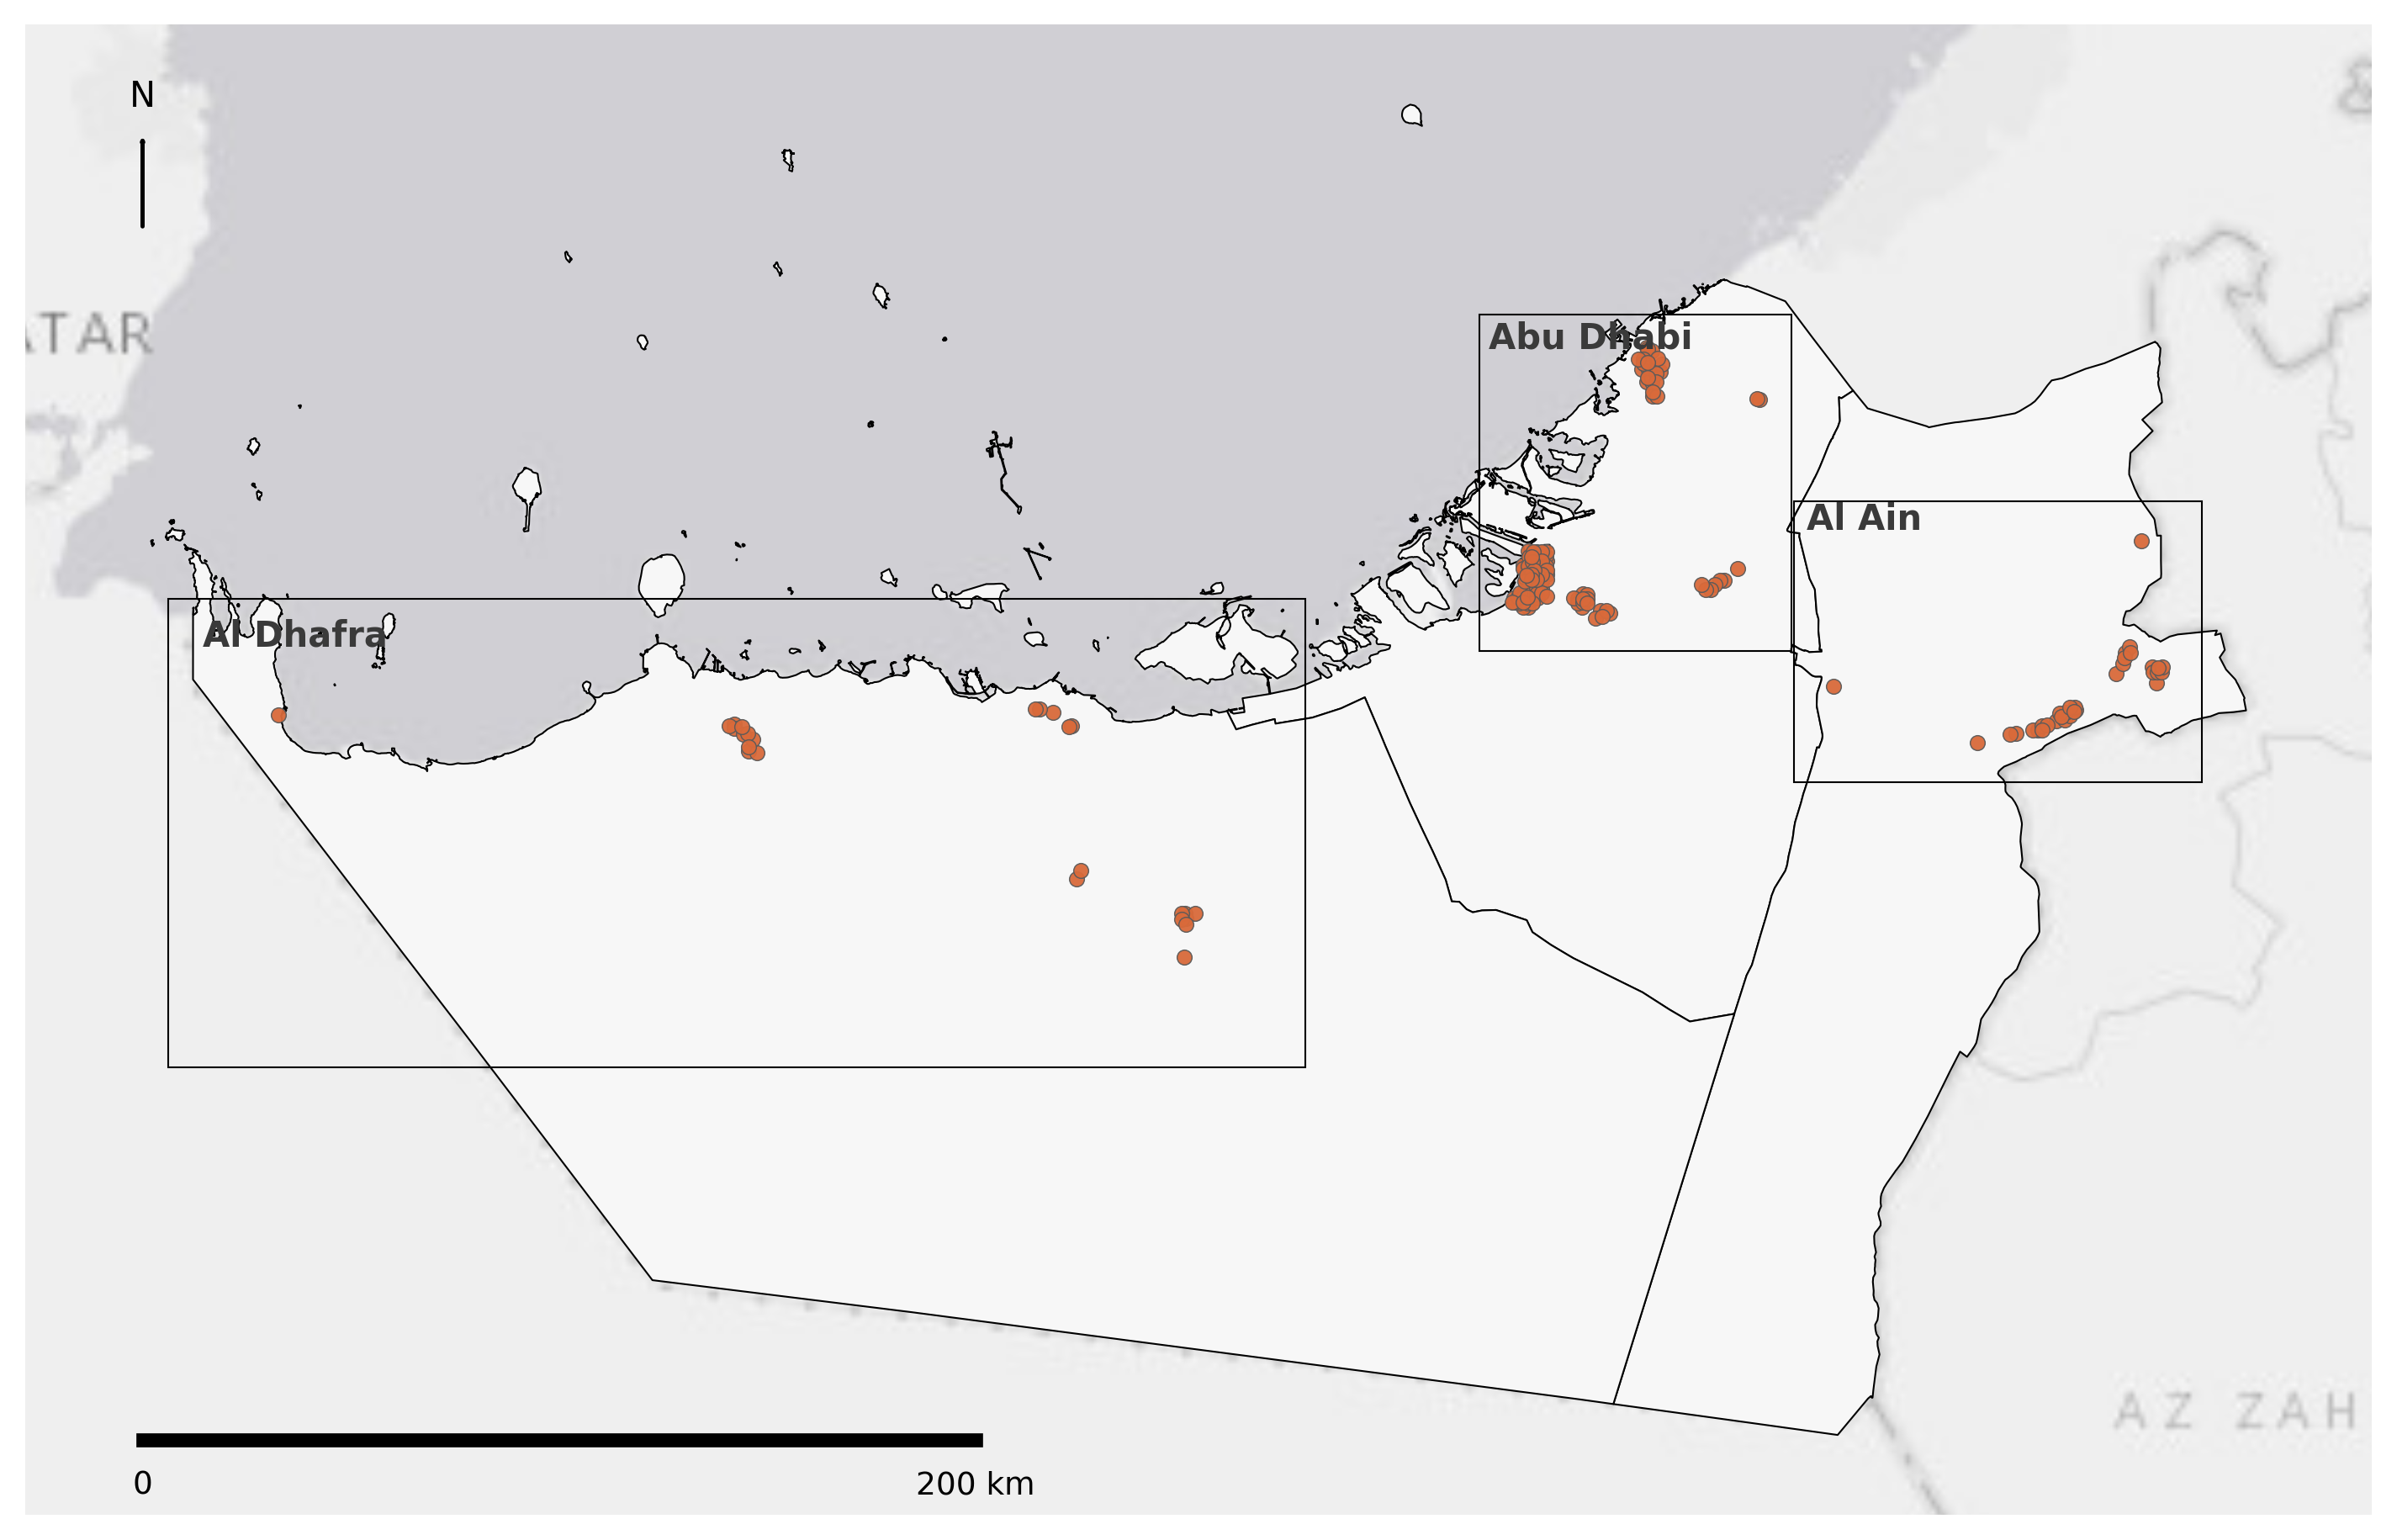

In [7]:
IND_COLOR = "#D96A3A"   # Industrial point color
SURVEY_ID = 9           # Industrial

# 你希望的 3 个区（匹配用关键词）
REGION_KEYWORDS = [
    ("Al Dhafra", ["Dhafra"]),
    ("Abu Dhabi", ["Abu Dhabi"]),
    ("Al Ain",    ["Ain"]),
]

# pad 设置：bbox 外扩（米）
PAD_MIN_M = 5000           # 最小 5 km
PAD_RATIO = 0.12           # 按点域宽高的比例外扩

# -------------------------
# Read data
# -------------------------
data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

# -------------------------
# Find region name field
# -------------------------
candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = None
for f in candidate_fields:
    if f in regions.columns:
        name_field = f
        break
if name_field is None:
    raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

# -------------------------
# Industrial points (dedup by SiteUID)
# -------------------------
sub = data[data["SurveyID"] == SURVEY_ID].copy()
sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID"])
sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

gdf = gpd.GeoDataFrame(
    sub,
    geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
    crs="EPSG:4326",
).to_crs(3857)

print("Industrial sites:", len(gdf))

# -------------------------
# Split regions (3 main regions)
# -------------------------
regions_3 = []
for label, keys in REGION_KEYWORDS:
    mask = np.zeros(len(regions), dtype=bool)
    for k in keys:
        mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
    reg = regions[mask].copy()
    if len(reg) == 0:
        print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
    regions_3.append((label, reg))

# -------------------------
# Compute AOI bboxes by "points inside region"
# -------------------------
region_aoi = []  # list of (label, bbox)
for label, reg_poly in regions_3:
    if len(reg_poly) == 0:
        continue

    # points within region polygon(s)
    pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()

    if len(pts_in) == 0:
        print(f"[WARN] No Industrial points inside region '{label}'. Skip AOI.")
        continue

    xmin, ymin, xmax, ymax = pts_in.total_bounds
    w = xmax - xmin
    h = ymax - ymin
    pad = max(PAD_MIN_M, PAD_RATIO * max(w, h))

    bbox = (xmin - pad, ymin - pad, xmax + pad, ymax + pad)
    region_aoi.append((label, bbox, pts_in))

    print(f"[INFO] {label}: points={len(pts_in)} pad(km)={pad/1000:.1f} bbox(km) w={(bbox[2]-bbox[0])/1000:.1f} h={(bbox[3]-bbox[1])/1000:.1f}")

# =================================================
# 1) FULL MAP (Industrial + 3 AOI rectangles)
# =================================================
fig, ax = plt.subplots(figsize=(12, 8))

xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.06 * (xmax - xmin)
ypad = 0.06 * (ymax - ymin)

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

cx.add_basemap(ax, source=BASEMAP, zoom=7, attribution=False)

regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=0.5, zorder=5)

ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    s=18, c=IND_COLOR,
    edgecolors="#5a5a5a",
    linewidths=0.35,
    alpha=0.95,
    zorder=10
)

# AOI rectangles + labels (optional)
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ax.add_patch(Rectangle((bxmin, bymin), bxmax-bxmin, bymax-bymin,
                           fill=False, edgecolor='black', linewidth=0.5, zorder=20))
    # 在框左上角稍微内缩写一个标签（全图可选）
    ax.text(bxmin + 0.03*(bxmax-bxmin), bymax - 0.1*(bymax-bymin),
            label, fontsize=10, weight="bold", color="#3a3a3a", zorder=21)

# 指北针 + 比例尺（沿用你的函数）
ax.set_axis_off()
add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

# 保存/显示
# fig.savefig(os.path.join(OUT_DIR, "Industrial_full_with_AOIs.png"), dpi=300, bbox_inches="tight")
plt.show()
fig.savefig(os.path.join(OUT_DIR, "Ch04_Industrial_full.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch04_Industrial_full.svg"), bbox_inches="tight", pad_inches=0.1)

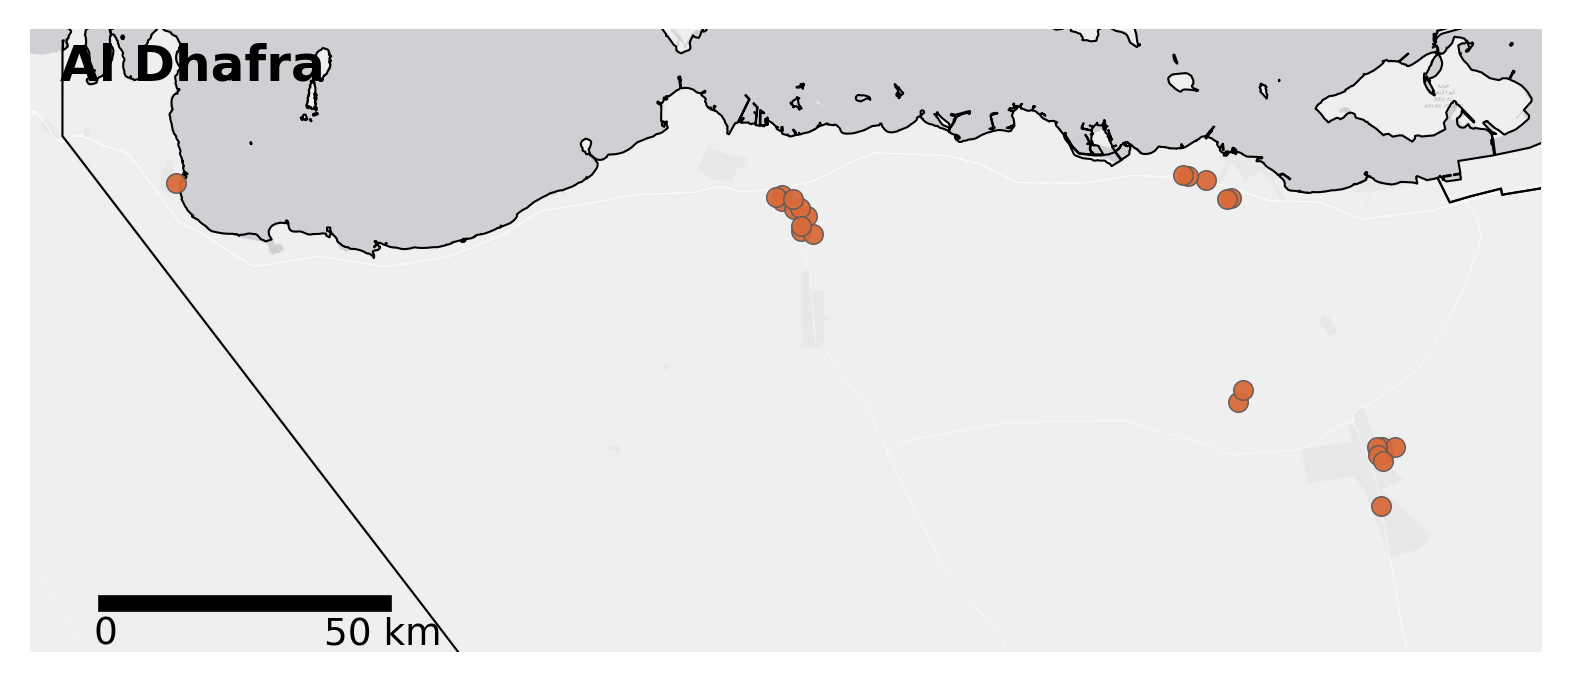

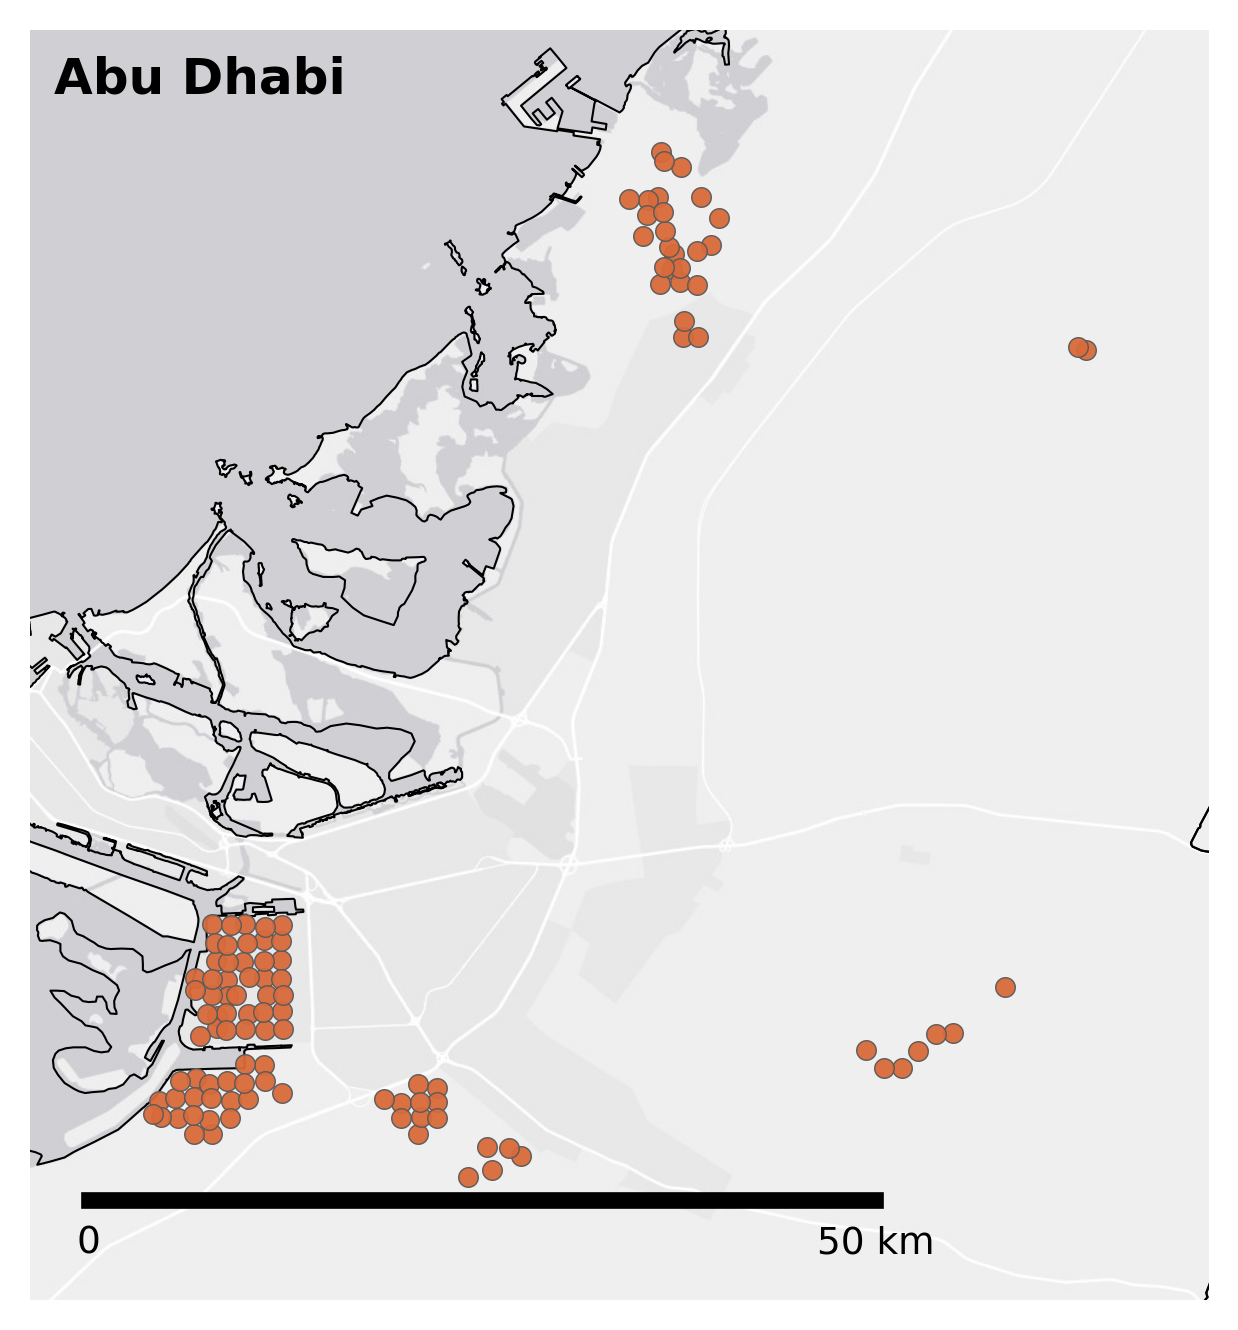

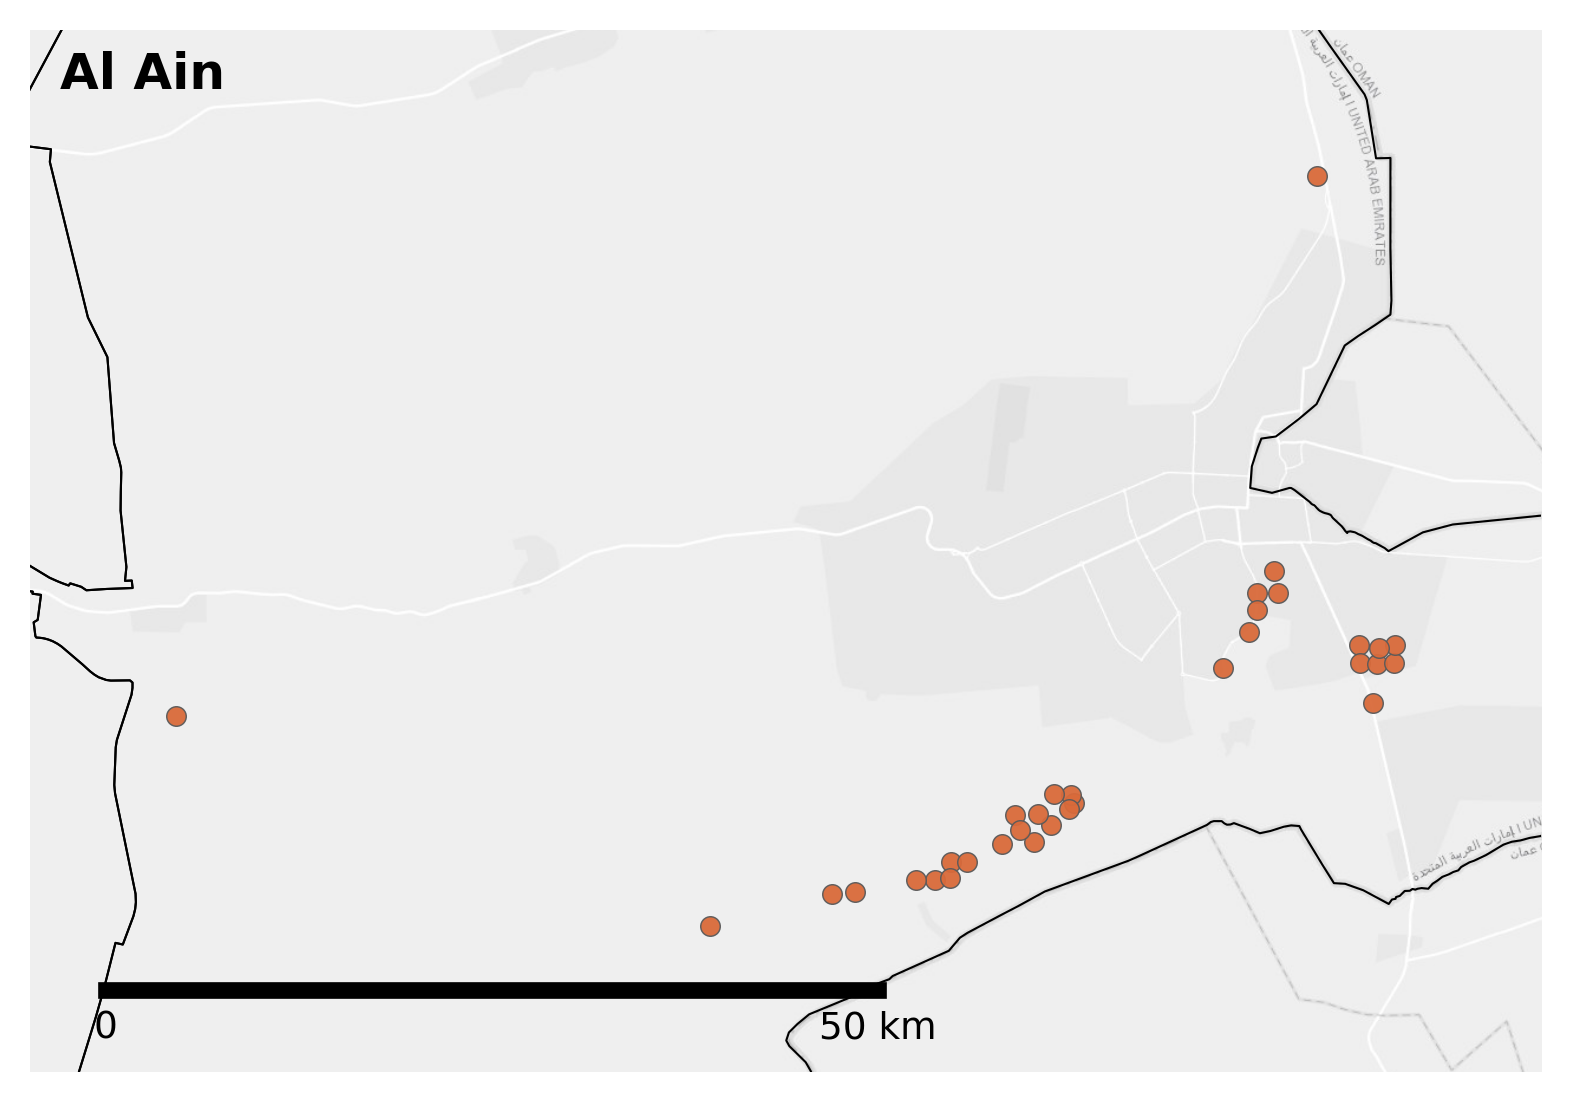

In [8]:
# =================================================
# 2) REGION MAPS (3 separate figures)
# =================================================
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ypad_local = 0.03 * (bymax - bymin)

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    ax.set_xlim(bxmin, bxmax)
    ax.set_ylim(bymin, bymax)

    cx.add_basemap(ax, source=BASEMAP, zoom=11, attribution=False)

    regions.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, zorder=5)

    ax.scatter(
        pts_in.geometry.x, pts_in.geometry.y,
        s=22, c=IND_COLOR,
        edgecolors="#5a5a5a",
        linewidths=0.35,
        alpha=0.95,
        zorder=10
    )

    # 左上角 region 标签（你明确要求）
    ax.text(
        0.02, 0.98, label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12, weight="bold",
        color="black",
        zorder=50
    )

    ax.set_axis_off()
    # add_north_arrow(ax)
    add_scale_bar(ax, bxmin, bymin + ypad_local, bxmax, bymax, length_km=50)

    # 保存/显示
    # fig.savefig(os.path.join(OUT_DIR, f"Industrial_{label.replace(' ', '_')}.png"), dpi=300, bbox_inches="tight")
    plt.show()
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_Industrial_{label.replace(' ', '_')}.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_Industrial_{label.replace(' ', '_')}.svg"), bbox_inches="tight", pad_inches=0.1)

# Figure 2 Location of the sampling sites for the  Residential Land Use in 2025

Industrial sites: 150
[INFO] Al Dhafra: points=21 pad(km)=27.2 bbox(km) w=280.6 h=171.7
[INFO] Abu Dhabi: points=97 pad(km)=6.1 bbox(km) w=63.1 h=58.4
[INFO] Al Ain: points=32 pad(km)=17.2 bbox(km) w=101.7 h=177.4


C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\2232239424.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\2232239424.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\2232239424.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()


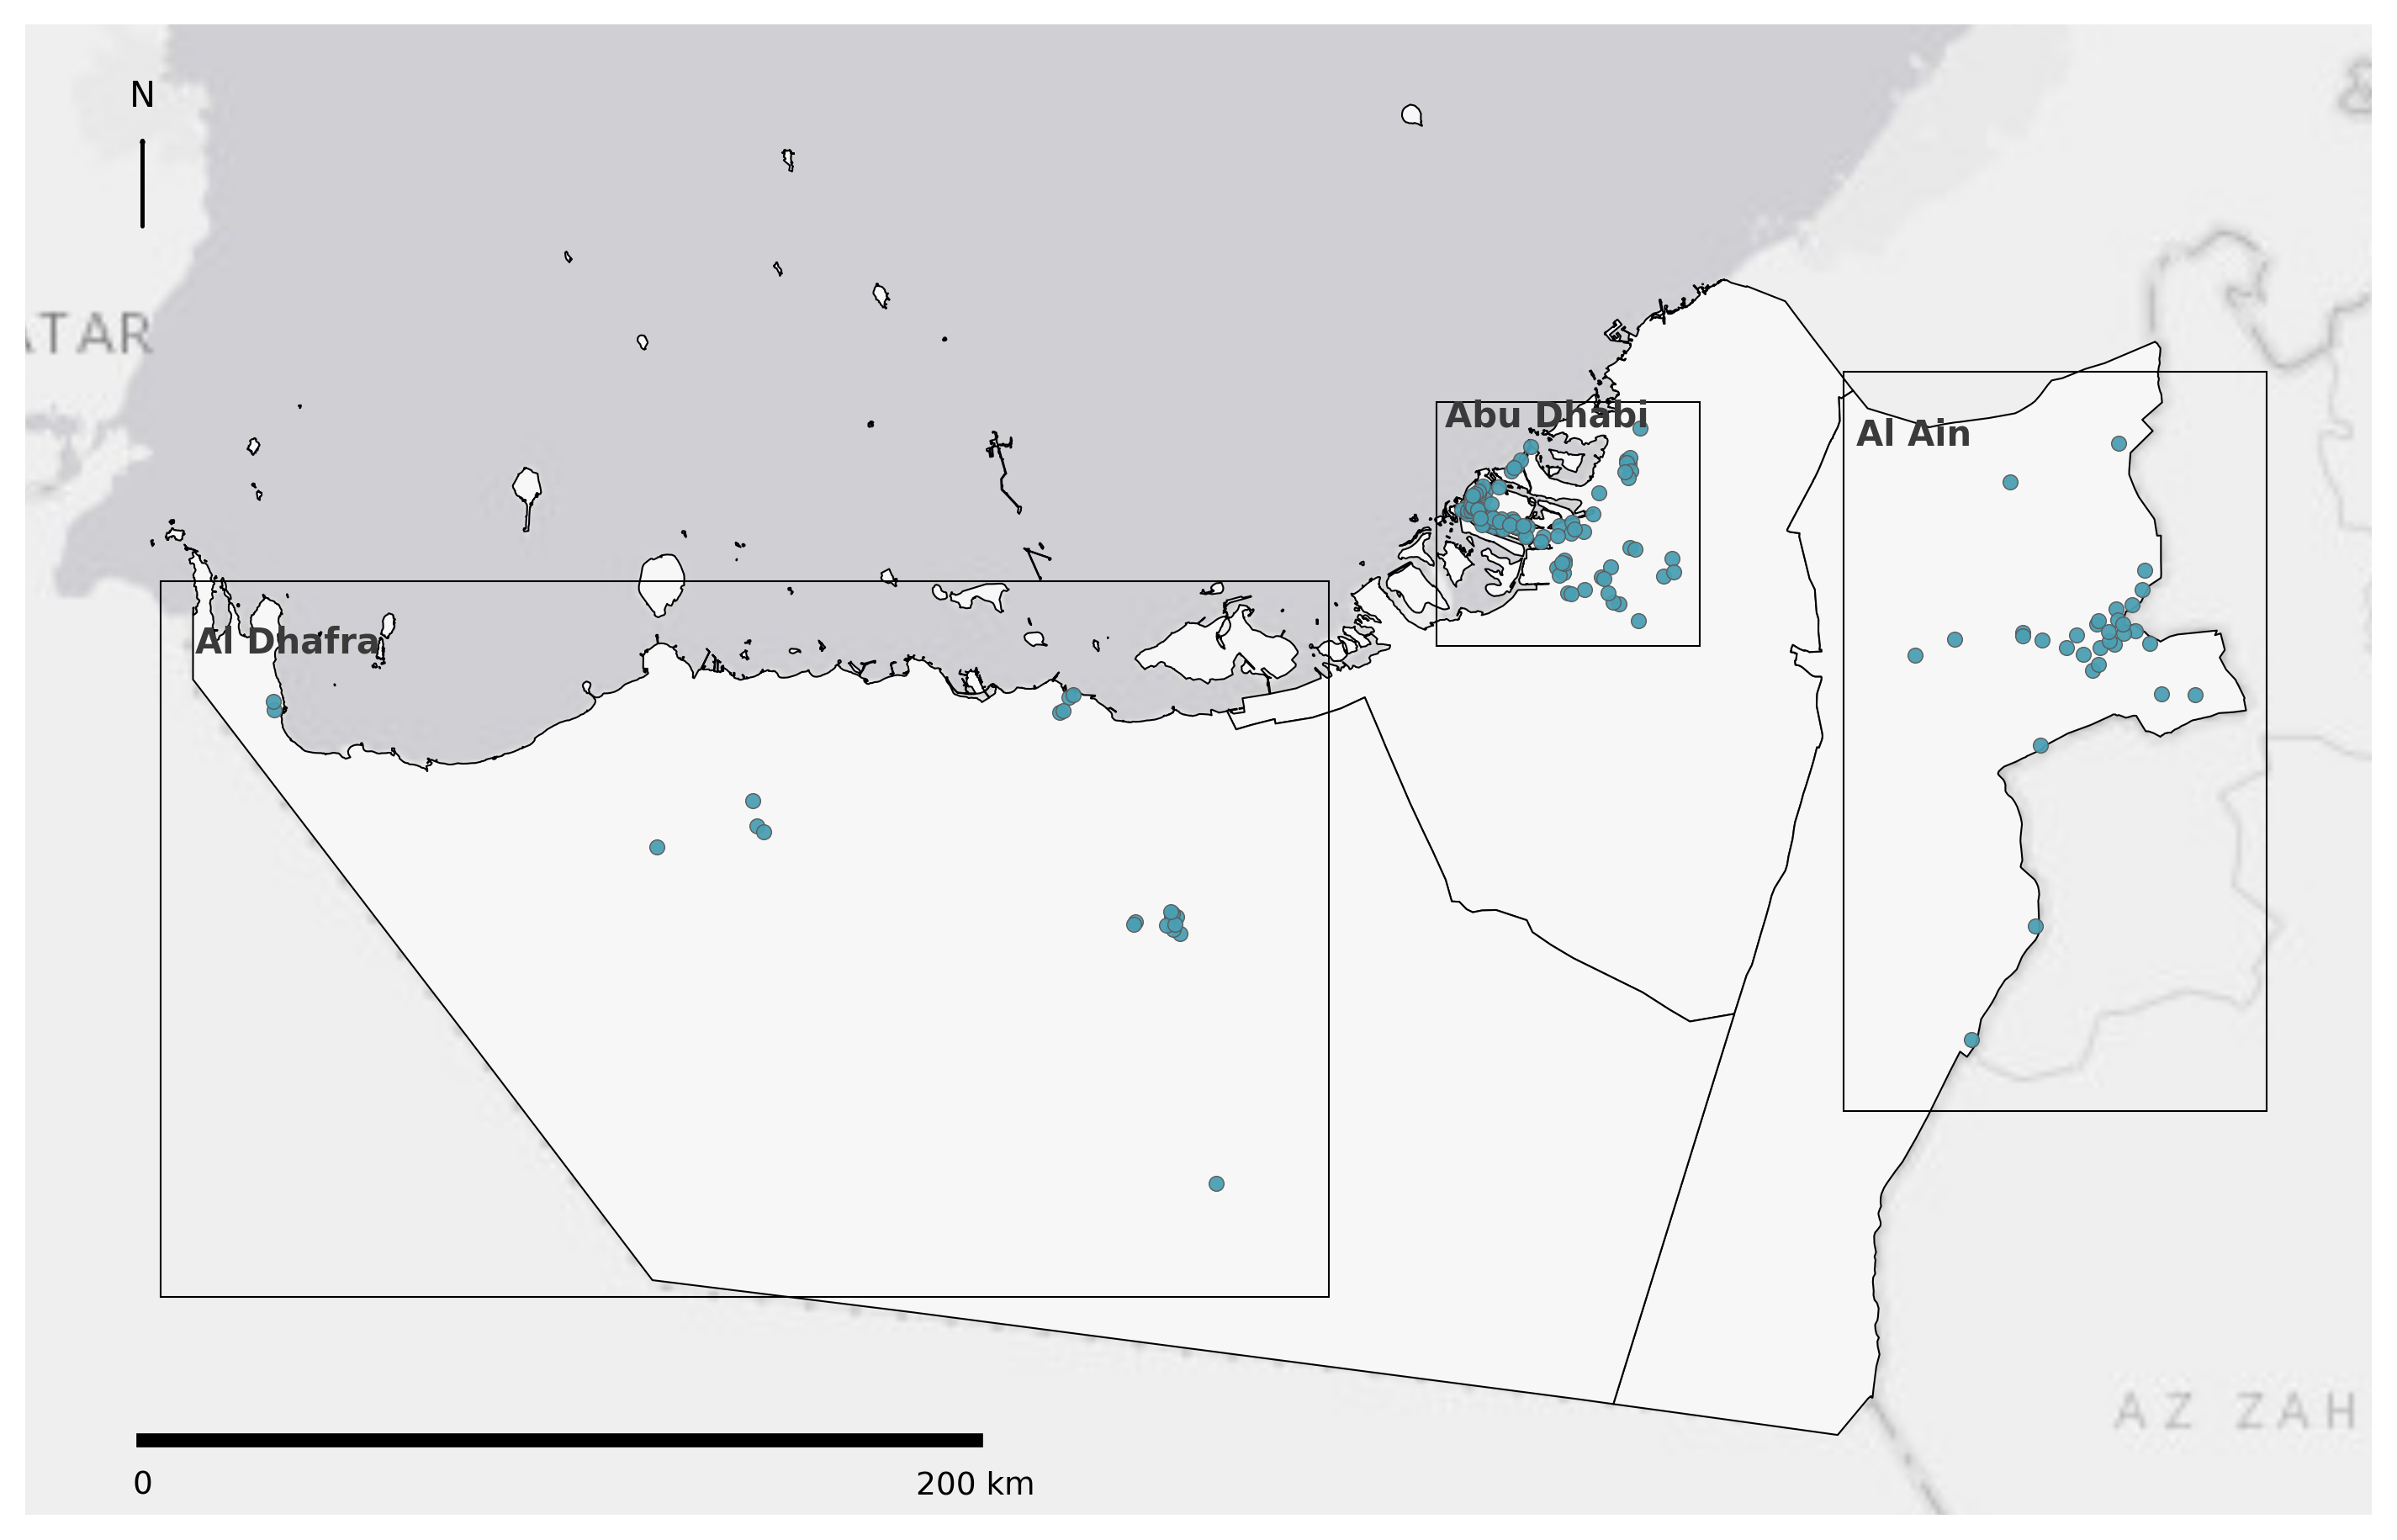

In [9]:
IND_COLOR = "#4B9FB3"  # Industrial point color
SURVEY_ID = 8  # Industrial

# 你希望的 3 个区（匹配用关键词）
REGION_KEYWORDS = [
    ("Al Dhafra", ["Dhafra"]),
    ("Abu Dhabi", ["Abu Dhabi"]),
    ("Al Ain", ["Ain"]),
]

# pad 设置：bbox 外扩（米）
PAD_MIN_M = 5000  # 最小 5 km
PAD_RATIO = 0.12  # 按点域宽高的比例外扩

# -------------------------
# Read data
# -------------------------
data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

# -------------------------
# Find region name field
# -------------------------
candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = None
for f in candidate_fields:
    if f in regions.columns:
        name_field = f
        break
if name_field is None:
    raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

# -------------------------
# Industrial points (dedup by SiteUID)
# -------------------------
sub = data[data["SurveyID"] == SURVEY_ID].copy()
sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID"])
sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

gdf = gpd.GeoDataFrame(
    sub,
    geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
    crs="EPSG:4326",
).to_crs(3857)

print("Industrial sites:", len(gdf))

# -------------------------
# Split regions (3 main regions)
# -------------------------
regions_3 = []
for label, keys in REGION_KEYWORDS:
    mask = np.zeros(len(regions), dtype=bool)
    for k in keys:
        mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
    reg = regions[mask].copy()
    if len(reg) == 0:
        print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
    regions_3.append((label, reg))

# -------------------------
# Compute AOI bboxes by "points inside region"
# -------------------------
region_aoi = []  # list of (label, bbox)
for label, reg_poly in regions_3:
    if len(reg_poly) == 0:
        continue

    # points within region polygon(s)
    pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()

    if len(pts_in) == 0:
        print(f"[WARN] No Industrial points inside region '{label}'. Skip AOI.")
        continue

    xmin, ymin, xmax, ymax = pts_in.total_bounds
    w = xmax - xmin
    h = ymax - ymin
    pad = max(PAD_MIN_M, PAD_RATIO * max(w, h))

    bbox = (xmin - pad, ymin - pad, xmax + pad, ymax + pad)
    region_aoi.append((label, bbox, pts_in))

    print(
        f"[INFO] {label}: points={len(pts_in)} pad(km)={pad / 1000:.1f} bbox(km) w={(bbox[2] - bbox[0]) / 1000:.1f} h={(bbox[3] - bbox[1]) / 1000:.1f}")

# =================================================
# 1) FULL MAP (Industrial + 3 AOI rectangles)
# =================================================
fig, ax = plt.subplots(figsize=(12, 8))

xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.06 * (xmax - xmin)
ypad = 0.06 * (ymax - ymin)

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

cx.add_basemap(ax, source=BASEMAP, zoom=7, attribution=False)

regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=0.5, zorder=5)

ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    s=18, c=IND_COLOR,
    edgecolors="#5a5a5a",
    linewidths=0.35,
    alpha=0.95,
    zorder=10
)

# AOI rectangles + labels (optional)
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ax.add_patch(Rectangle((bxmin, bymin), bxmax - bxmin, bymax - bymin,
                           fill=False, edgecolor='black', linewidth=0.5, zorder=20))
    # 在框左上角稍微内缩写一个标签（全图可选）
    ax.text(bxmin + 0.03 * (bxmax - bxmin), bymax - 0.1 * (bymax - bymin),
            label, fontsize=10, weight="bold", color="#3a3a3a", zorder=21)

# 指北针 + 比例尺（沿用你的函数）
ax.set_axis_off()
add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

# 保存/显示
# fig.savefig(os.path.join(OUT_DIR, "Industrial_full_with_AOIs.png"), dpi=300, bbox_inches="tight")
plt.show()
fig.savefig(os.path.join(OUT_DIR, "Ch04_Residential_full.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch04_Residential_full.svg"), bbox_inches="tight", pad_inches=0.1)

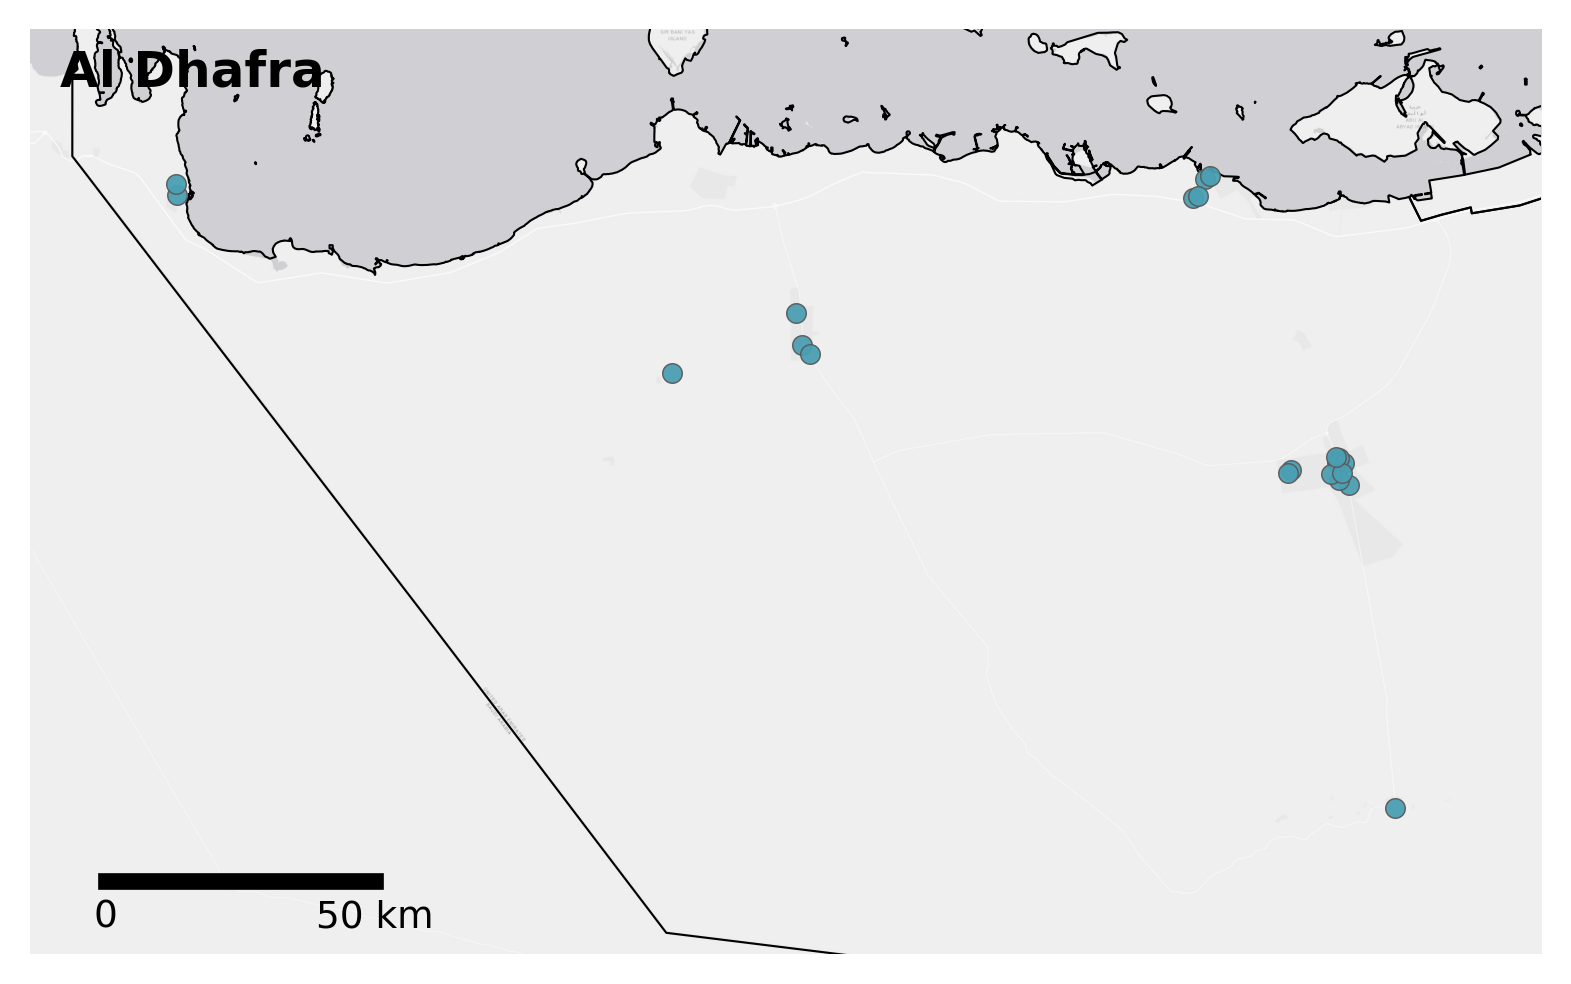

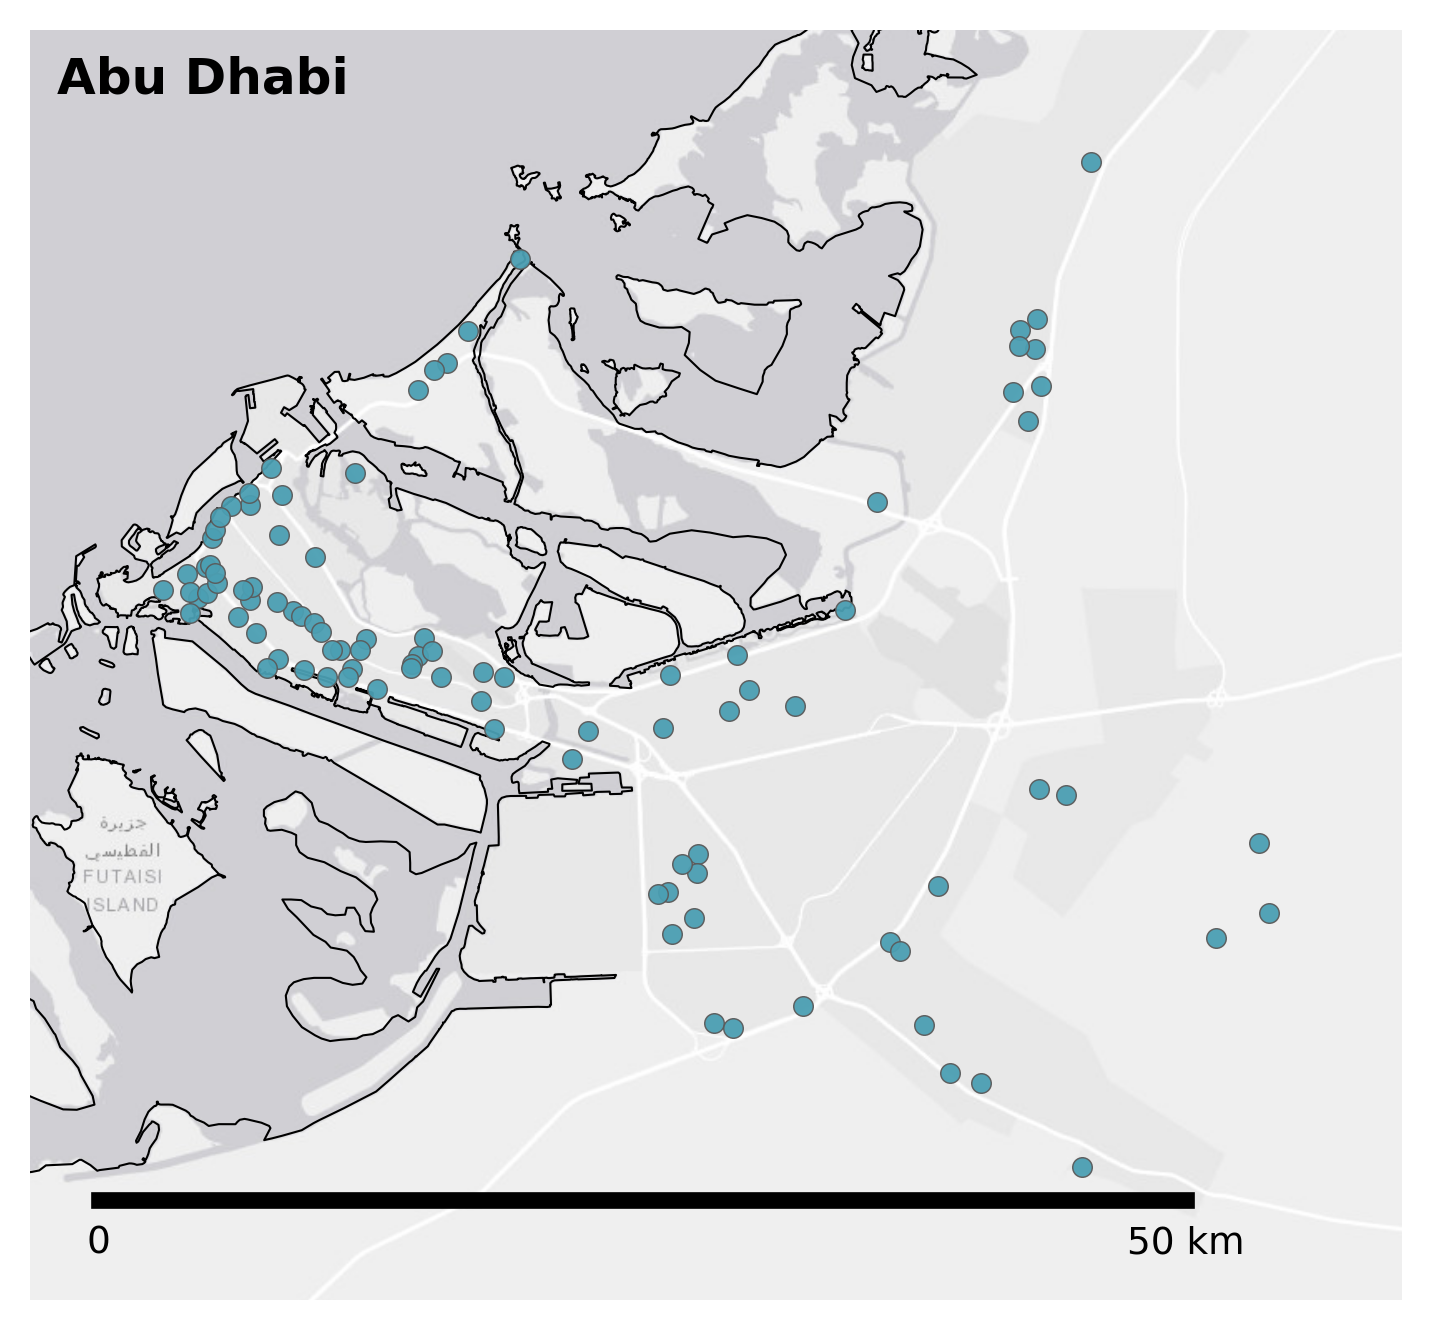

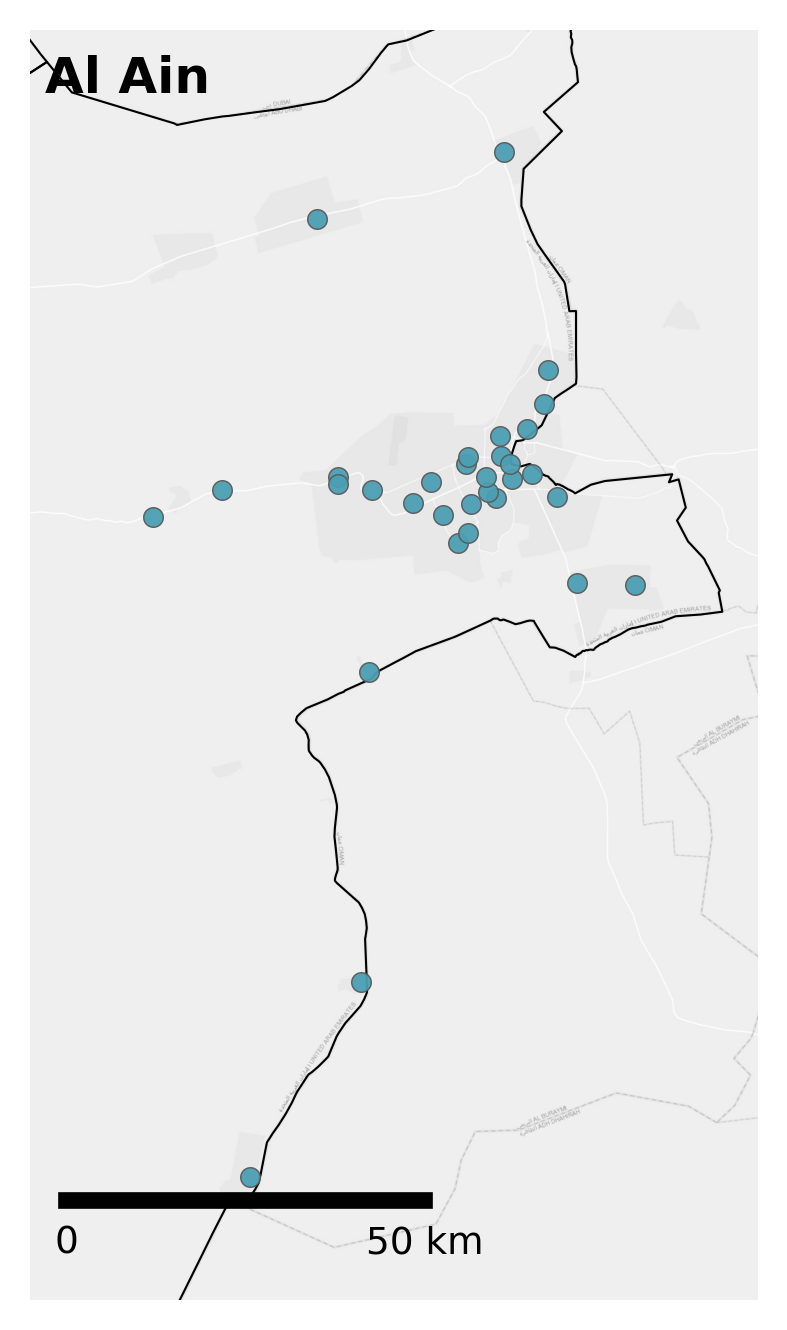

In [10]:
# =================================================
# 2) REGION MAPS (3 separate figures)
# =================================================
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ypad_local = 0.03 * (bymax - bymin)

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    ax.set_xlim(bxmin, bxmax)
    ax.set_ylim(bymin, bymax)

    cx.add_basemap(ax, source=BASEMAP, zoom=11, attribution=False)

    regions.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, zorder=5)

    ax.scatter(
        pts_in.geometry.x, pts_in.geometry.y,
        s=22, c=IND_COLOR,
        edgecolors="#5a5a5a",
        linewidths=0.35,
        alpha=0.95,
        zorder=10
    )

    # 左上角 region 标签（你明确要求）
    ax.text(
        0.02, 0.98, label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12, weight="bold",
        color="black",
        zorder=50
    )

    ax.set_axis_off()
    # add_north_arrow(ax)
    add_scale_bar(ax, bxmin, bymin + ypad_local, bxmax, bymax, length_km=50)

    # 保存/显示
    # fig.savefig(os.path.join(OUT_DIR, f"Industrial_{label.replace(' ', '_')}.png"), dpi=300, bbox_inches="tight")
    plt.show()
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_Residential_{label.replace(' ', '_')}.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_Residential_{label.replace(' ', '_')}.svg"), bbox_inches="tight", pad_inches=0.1)

# Figure 3 Location of the sampling sites for the  Agricultural Land Use in 2025

Industrial sites: 306
[INFO] Al Dhafra: points=88 pad(km)=35.9 bbox(km) w=370.5 h=211.2
[INFO] Abu Dhabi: points=61 pad(km)=7.9 bbox(km) w=69.9 h=81.7
[INFO] Al Ain: points=157 pad(km)=19.2 bbox(km) w=133.3 h=198.6


C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\68758685.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\68758685.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\68758685.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()


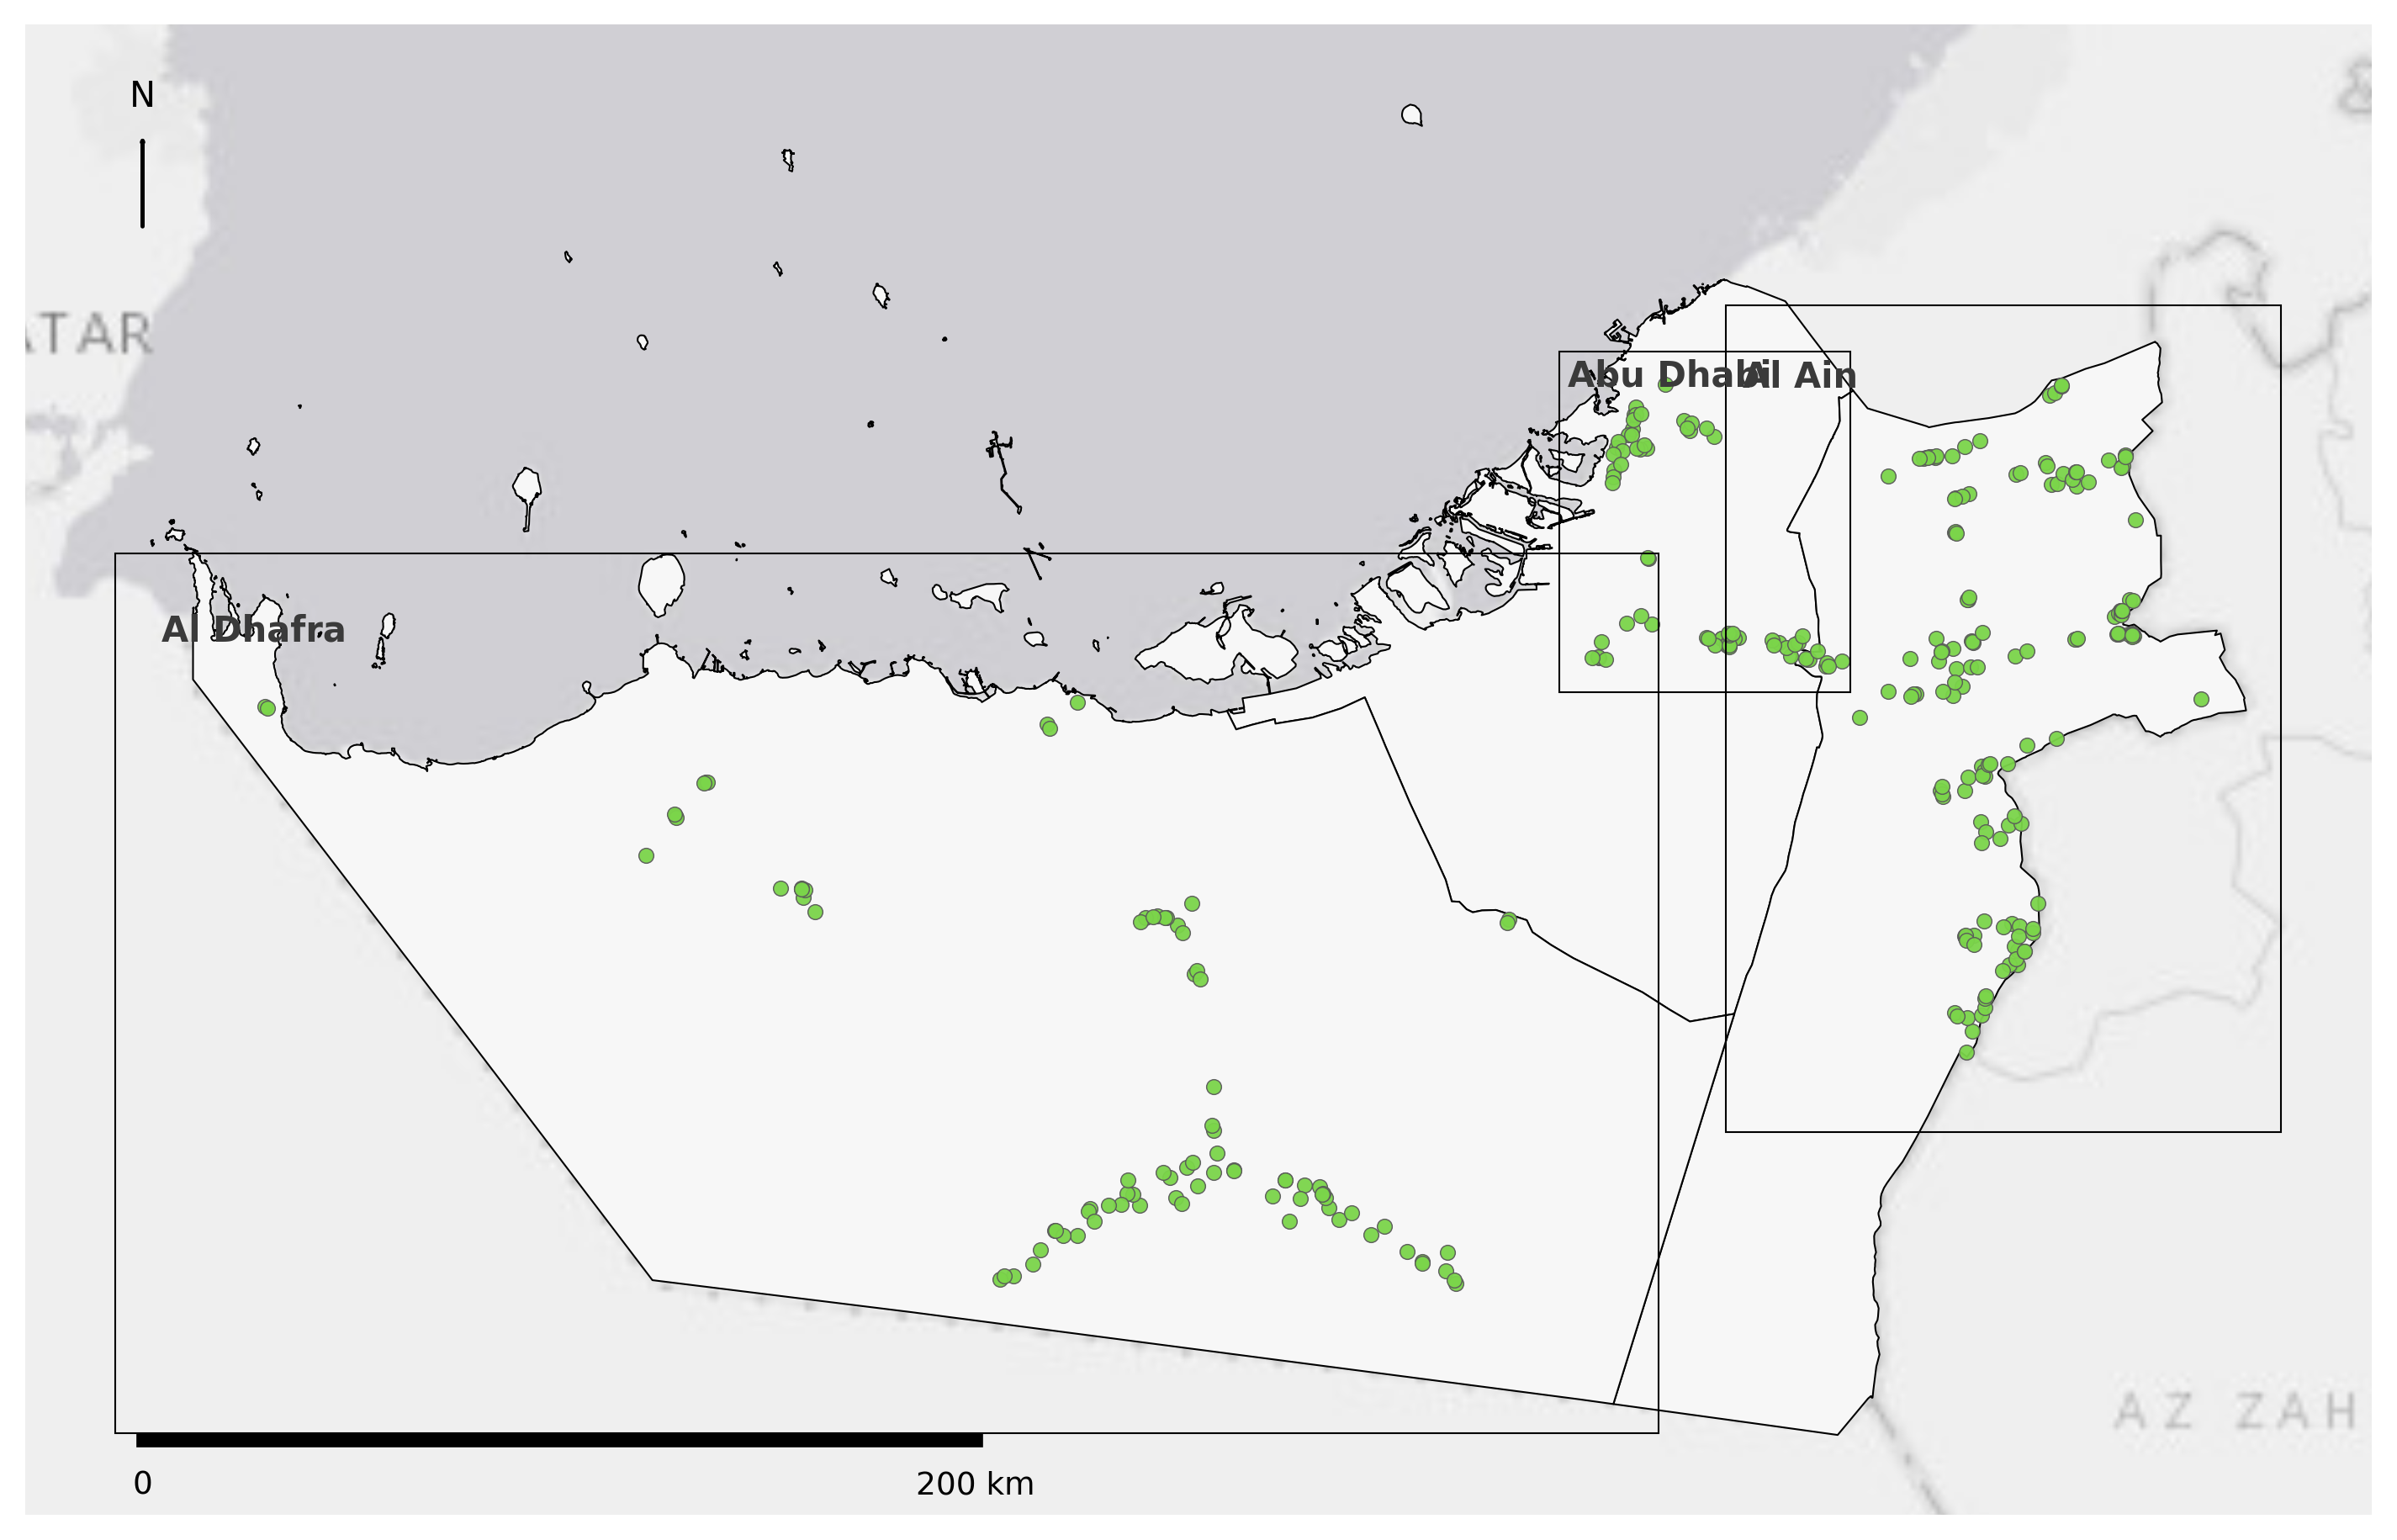

In [11]:
IND_COLOR = "#7BD54A"  # Industrial point color
SURVEY_ID = 7  # Industrial

# 你希望的 3 个区（匹配用关键词）
REGION_KEYWORDS = [
    ("Al Dhafra", ["Dhafra"]),
    ("Abu Dhabi", ["Abu Dhabi"]),
    ("Al Ain", ["Ain"]),
]

# pad 设置：bbox 外扩（米）
PAD_MIN_M = 5000  # 最小 5 km
PAD_RATIO = 0.12  # 按点域宽高的比例外扩

# -------------------------
# Read data
# -------------------------
data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

# -------------------------
# Find region name field
# -------------------------
candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = None
for f in candidate_fields:
    if f in regions.columns:
        name_field = f
        break
if name_field is None:
    raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

# -------------------------
# Industrial points (dedup by SiteUID)
# -------------------------
sub = data[data["SurveyID"] == SURVEY_ID].copy()
sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID"])
sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

gdf = gpd.GeoDataFrame(
    sub,
    geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
    crs="EPSG:4326",
).to_crs(3857)

print("Industrial sites:", len(gdf))

# -------------------------
# Split regions (3 main regions)
# -------------------------
regions_3 = []
for label, keys in REGION_KEYWORDS:
    mask = np.zeros(len(regions), dtype=bool)
    for k in keys:
        mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
    reg = regions[mask].copy()
    if len(reg) == 0:
        print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
    regions_3.append((label, reg))

# -------------------------
# Compute AOI bboxes by "points inside region"
# -------------------------
region_aoi = []  # list of (label, bbox)
for label, reg_poly in regions_3:
    if len(reg_poly) == 0:
        continue

    # points within region polygon(s)
    pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()

    if len(pts_in) == 0:
        print(f"[WARN] No Industrial points inside region '{label}'. Skip AOI.")
        continue

    xmin, ymin, xmax, ymax = pts_in.total_bounds
    w = xmax - xmin
    h = ymax - ymin
    pad = max(PAD_MIN_M, PAD_RATIO * max(w, h))

    bbox = (xmin - pad, ymin - pad, xmax + pad, ymax + pad)
    region_aoi.append((label, bbox, pts_in))

    print(
        f"[INFO] {label}: points={len(pts_in)} pad(km)={pad / 1000:.1f} bbox(km) w={(bbox[2] - bbox[0]) / 1000:.1f} h={(bbox[3] - bbox[1]) / 1000:.1f}")

# =================================================
# 1) FULL MAP (Industrial + 3 AOI rectangles)
# =================================================
fig, ax = plt.subplots(figsize=(12, 8))

xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.06 * (xmax - xmin)
ypad = 0.06 * (ymax - ymin)

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

cx.add_basemap(ax, source=BASEMAP, zoom=7, attribution=False)

regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=0.5, zorder=5)

ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    s=18, c=IND_COLOR,
    edgecolors="#5a5a5a",
    linewidths=0.35,
    alpha=0.95,
    zorder=10
)

# AOI rectangles + labels (optional)
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ax.add_patch(Rectangle((bxmin, bymin), bxmax - bxmin, bymax - bymin,
                           fill=False, edgecolor='black', linewidth=0.5, zorder=20))
    # 在框左上角稍微内缩写一个标签（全图可选）
    ax.text(bxmin + 0.03 * (bxmax - bxmin), bymax - 0.1 * (bymax - bymin),
            label, fontsize=10, weight="bold", color="#3a3a3a", zorder=21)

# 指北针 + 比例尺（沿用你的函数）
ax.set_axis_off()
add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

# 保存/显示
# fig.savefig(os.path.join(OUT_DIR, "Industrial_full_with_AOIs.png"), dpi=300, bbox_inches="tight")
plt.show()
fig.savefig(os.path.join(OUT_DIR, "Ch04_Agriculture_full.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch04_Agriculture_full.svg"), bbox_inches="tight", pad_inches=0.1)


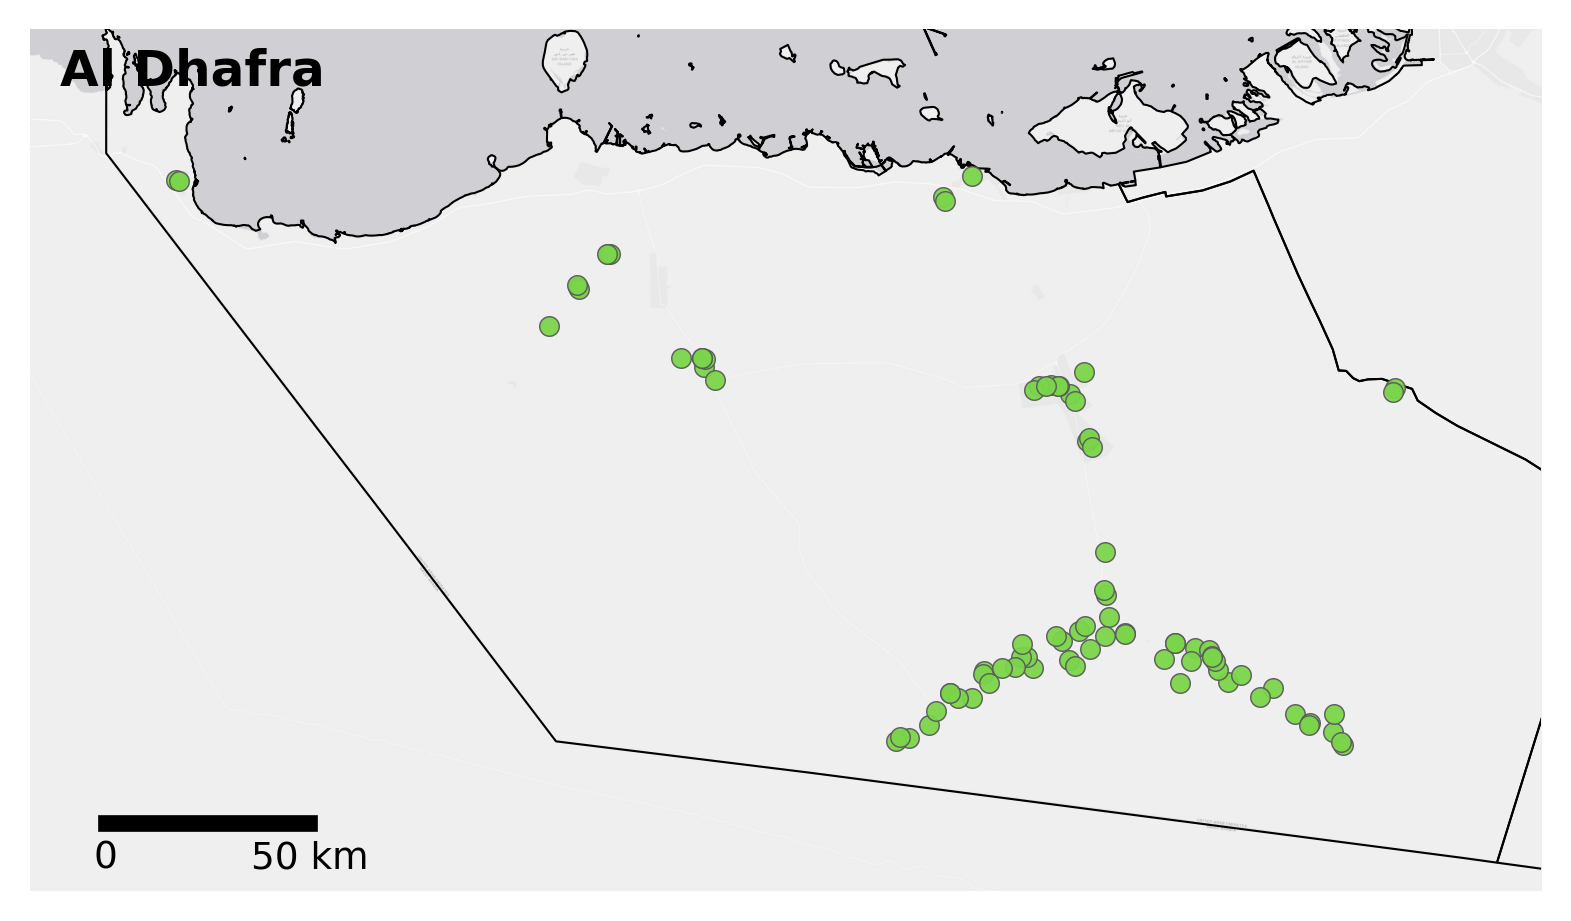

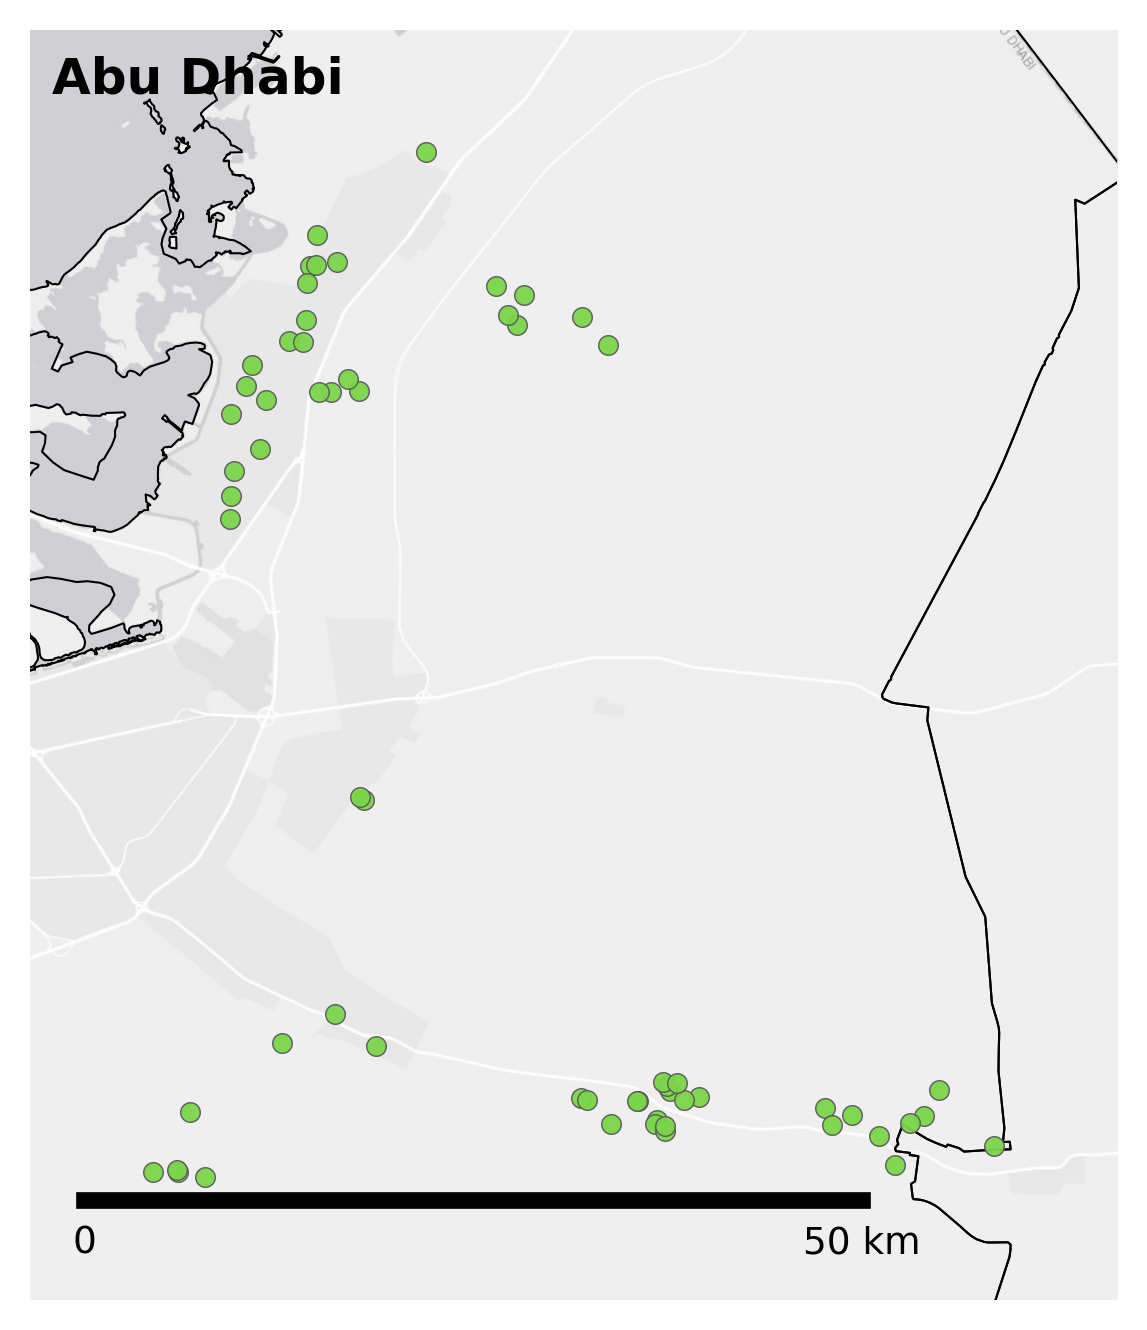

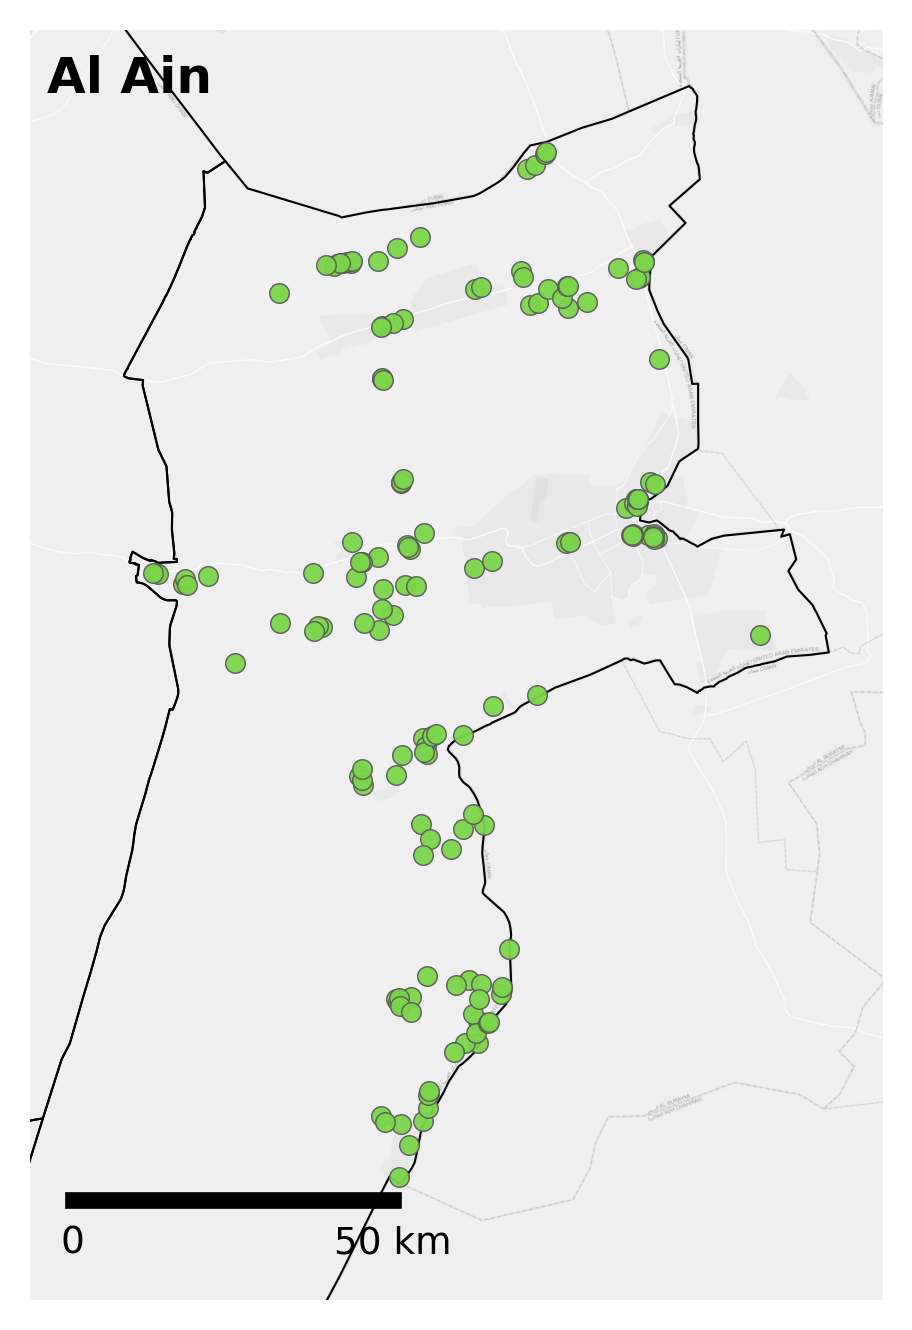

In [12]:
# =================================================
# 2) REGION MAPS (3 separate figures)
# =================================================
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ypad_local = 0.03 * (bymax - bymin)

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    ax.set_xlim(bxmin, bxmax)
    ax.set_ylim(bymin, bymax)

    cx.add_basemap(ax, source=BASEMAP, zoom=11, attribution=False)

    regions.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, zorder=5)

    ax.scatter(
        pts_in.geometry.x, pts_in.geometry.y,
        s=22, c=IND_COLOR,
        edgecolors="#5a5a5a",
        linewidths=0.35,
        alpha=0.95,
        zorder=10
    )

    # 左上角 region 标签（你明确要求）
    ax.text(
        0.02, 0.98, label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12, weight="bold",
        color="black",
        zorder=50
    )

    ax.set_axis_off()
    # add_north_arrow(ax)
    add_scale_bar(ax, bxmin, bymin + ypad_local, bxmax, bymax, length_km=50)

    # 保存/显示
    # fig.savefig(os.path.join(OUT_DIR, f"Industrial_{label.replace(' ', '_')}.png"), dpi=300, bbox_inches="tight")
    plt.show()
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_Agriculture_{label.replace(' ', '_')}.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_Agriculture_{label.replace(' ', '_')}.svg"), bbox_inches="tight", pad_inches=0.1)

# Figure 4 Location of the sampling sites for the Non-Developed Land Use in 2025

Industrial sites: 84
[INFO] Al Dhafra: points=48 pad(km)=39.8 bbox(km) w=411.4 h=261.2
[INFO] Abu Dhabi: points=16 pad(km)=18.7 bbox(km) w=155.9 h=192.9
[INFO] Al Ain: points=20 pad(km)=27.2 bbox(km) w=143.9 h=281.4


C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\4229488177.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\4229488177.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_13332\4229488177.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()


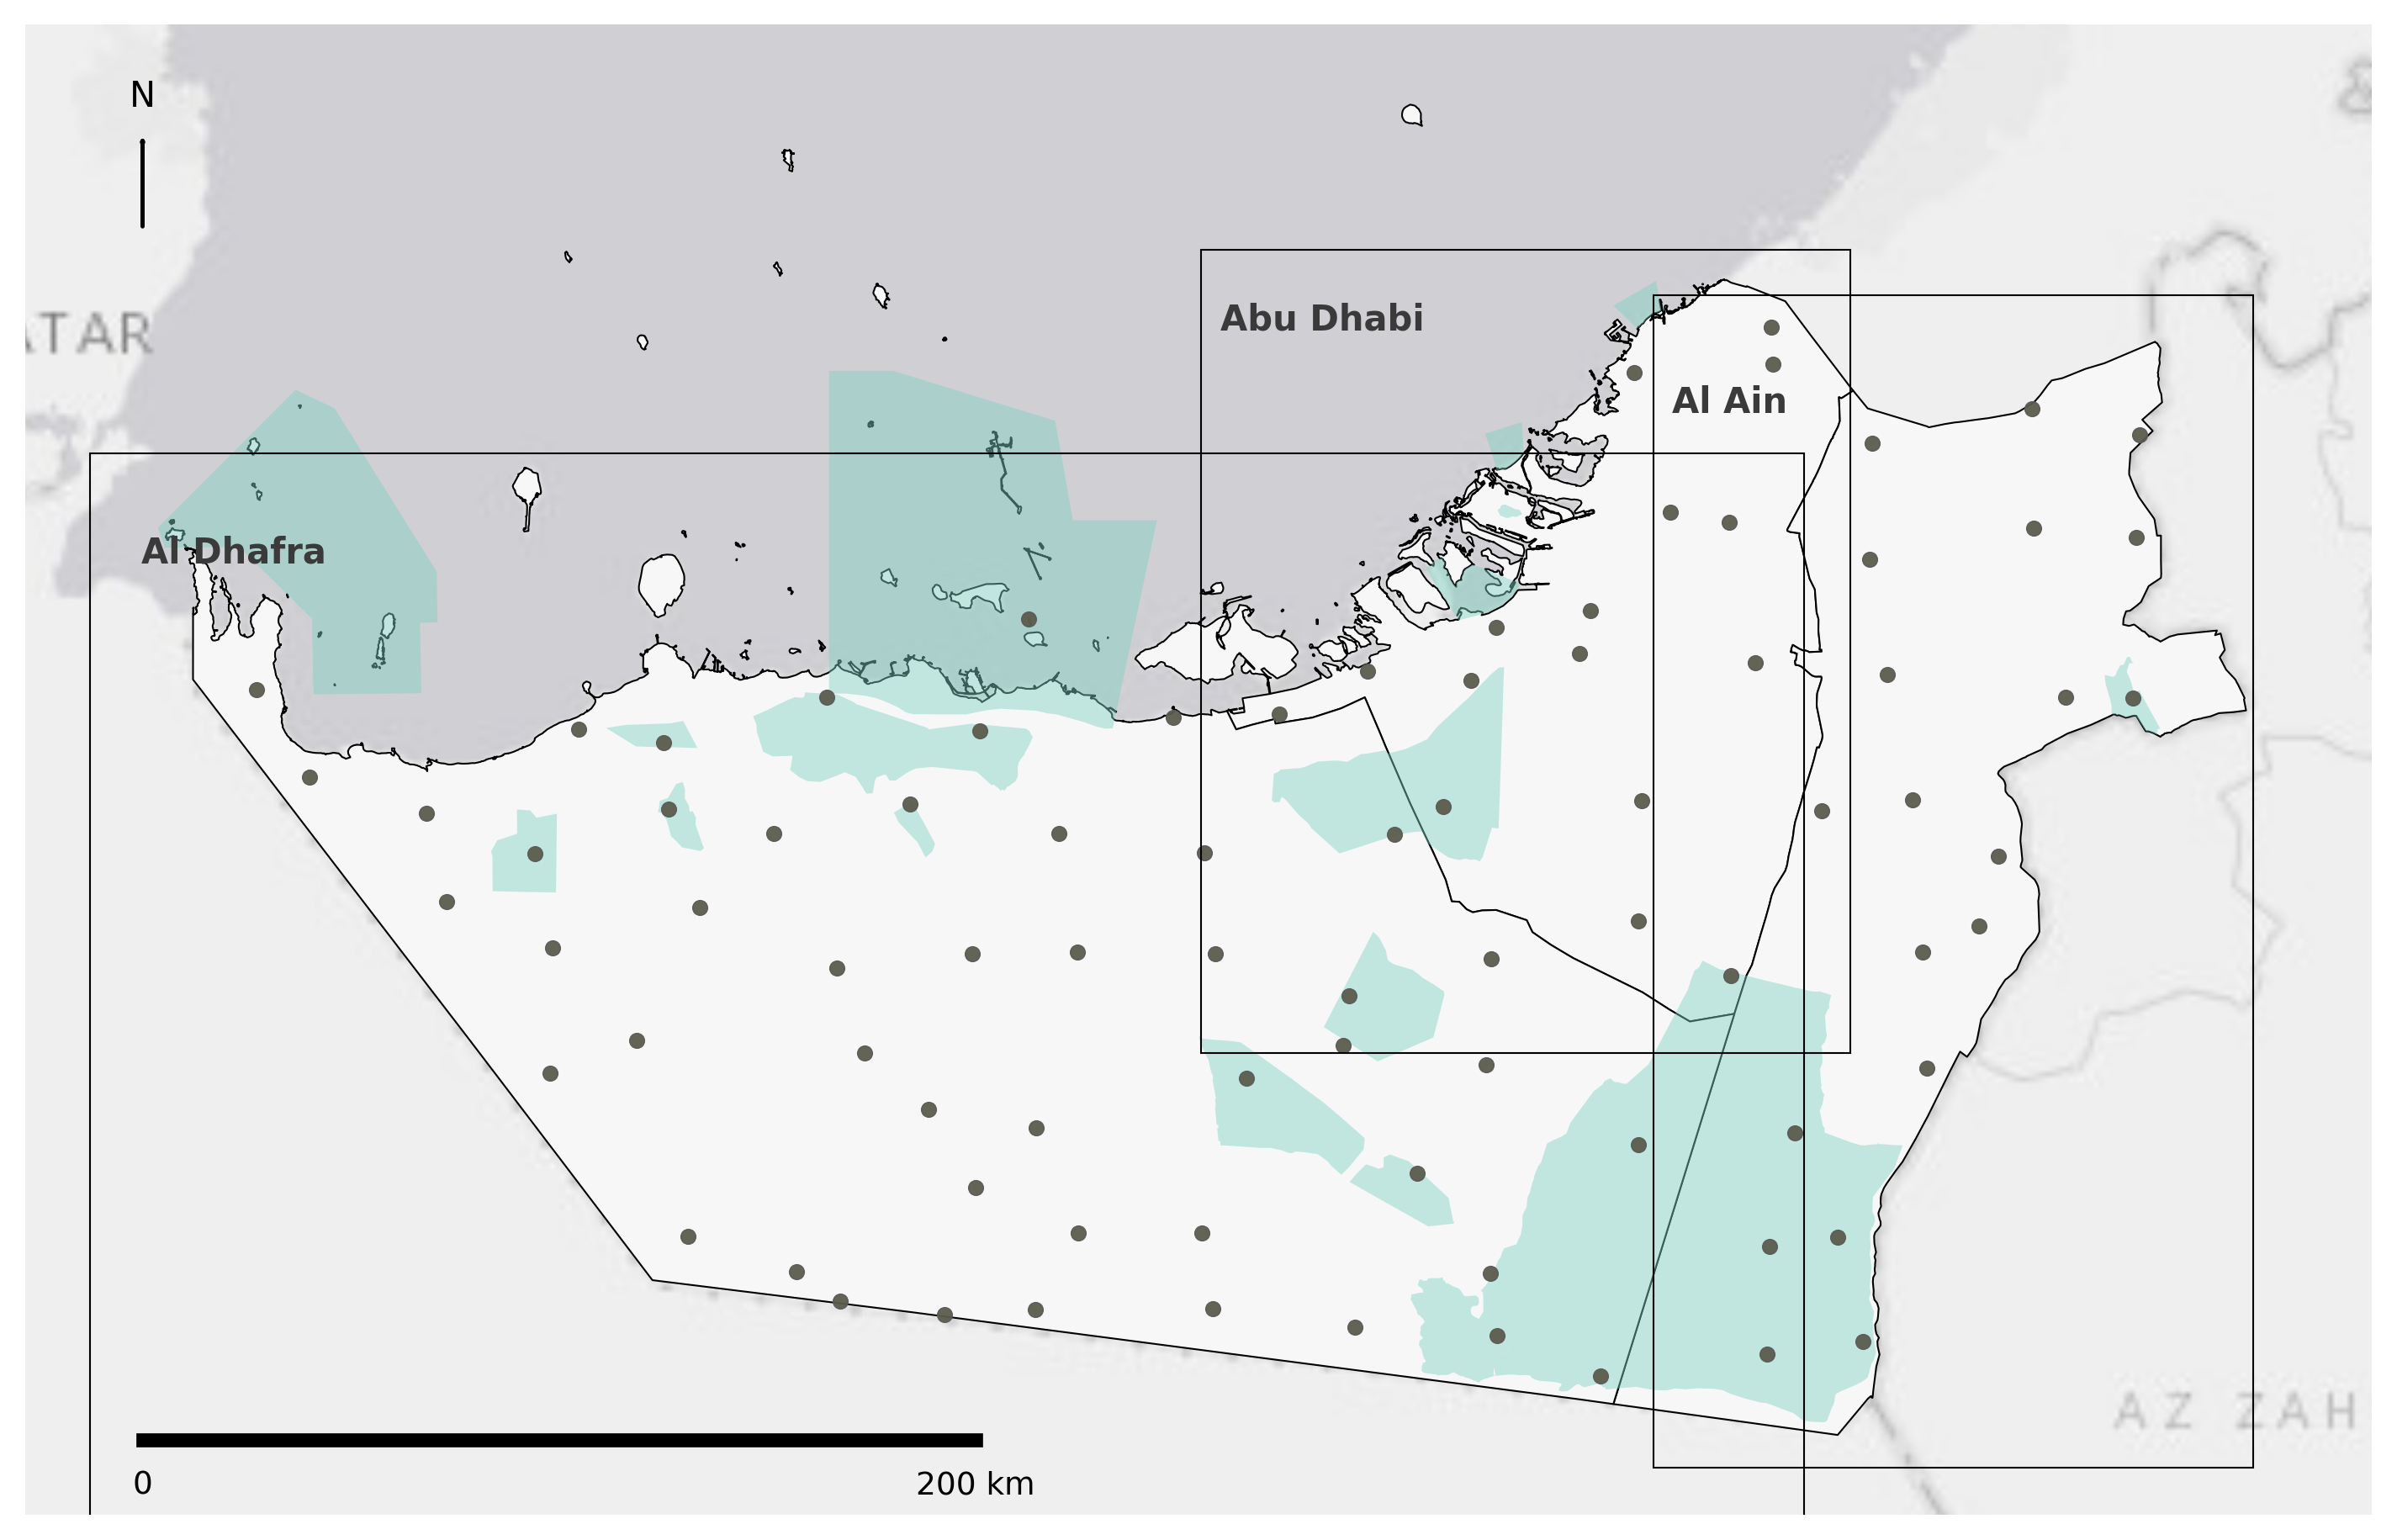

In [13]:
IND_COLOR = "#5B5B4D"  # Industrial point color
SURVEY_ID = 11  # Industrial

# 你希望的 3 个区（匹配用关键词）
REGION_KEYWORDS = [
    ("Al Dhafra", ["Dhafra"]),
    ("Abu Dhabi", ["Abu Dhabi"]),
    ("Al Ain", ["Ain"]),
]

# pad 设置：bbox 外扩（米）
PAD_MIN_M = 5000  # 最小 5 km
PAD_RATIO = 0.12  # 按点域宽高的比例外扩

# -------------------------
# Read protected areas
# -------------------------
protected = gpd.read_file(PROTECTED_GPKG, layer=PROTECTED_LAYER).to_crs(3857)
protected = protected[(~protected.geometry.isna()) & (~protected.geometry.is_empty)].copy()
# -------------------------
# Read data
# -------------------------
data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

# -------------------------
# Find region name field
# -------------------------
candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = None
for f in candidate_fields:
    if f in regions.columns:
        name_field = f
        break
if name_field is None:
    raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

# -------------------------
# Industrial points (dedup by SiteUID)
# -------------------------
sub = data[data["SurveyID"] == SURVEY_ID].copy()
sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID"])
sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

gdf = gpd.GeoDataFrame(
    sub,
    geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
    crs="EPSG:4326",
).to_crs(3857)

print("Industrial sites:", len(gdf))

# -------------------------
# Split regions (3 main regions)
# -------------------------
regions_3 = []
for label, keys in REGION_KEYWORDS:
    mask = np.zeros(len(regions), dtype=bool)
    for k in keys:
        mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
    reg = regions[mask].copy()
    if len(reg) == 0:
        print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
    regions_3.append((label, reg))

# -------------------------
# Compute AOI bboxes by "points inside region"
# -------------------------
region_aoi = []  # list of (label, bbox)
for label, reg_poly in regions_3:
    if len(reg_poly) == 0:
        continue

    # points within region polygon(s)
    pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()

    if len(pts_in) == 0:
        print(f"[WARN] No Industrial points inside region '{label}'. Skip AOI.")
        continue

    xmin, ymin, xmax, ymax = pts_in.total_bounds
    w = xmax - xmin
    h = ymax - ymin
    pad = max(PAD_MIN_M, PAD_RATIO * max(w, h))

    bbox = (xmin - pad, ymin - pad, xmax + pad, ymax + pad)
    region_aoi.append((label, bbox, pts_in))

    print(
        f"[INFO] {label}: points={len(pts_in)} pad(km)={pad / 1000:.1f} bbox(km) w={(bbox[2] - bbox[0]) / 1000:.1f} h={(bbox[3] - bbox[1]) / 1000:.1f}")

# =================================================
# 1) FULL MAP (Industrial + 3 AOI rectangles)
# =================================================
fig, ax = plt.subplots(figsize=(12, 8))

xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.06 * (xmax - xmin)
ypad = 0.06 * (ymax - ymin)

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

cx.add_basemap(ax, source=BASEMAP, zoom=7, attribution=False)

regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=0.5, zorder=5)
protected.plot(
    ax=ax,
    facecolor="#7FD3C3",
    edgecolor="none",
    alpha=0.45,
    zorder=6
)

ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    s=18, c=IND_COLOR,
    edgecolors="#5a5a5a",
    linewidths=0.35,
    alpha=0.95,
    zorder=10
)

# AOI rectangles + labels (optional)
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ax.add_patch(Rectangle((bxmin, bymin), bxmax - bxmin, bymax - bymin,
                           fill=False, edgecolor='black', linewidth=0.5, zorder=20))
    # 在框左上角稍微内缩写一个标签（全图可选）
    ax.text(bxmin + 0.03 * (bxmax - bxmin), bymax - 0.1 * (bymax - bymin),
            label, fontsize=10, weight="bold", color="#3a3a3a", zorder=21)

# 指北针 + 比例尺（沿用你的函数）
ax.set_axis_off()
add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

# 保存/显示
# fig.savefig(os.path.join(OUT_DIR, "Industrial_full_with_AOIs.png"), dpi=300, bbox_inches="tight")
plt.show()
fig.savefig(os.path.join(OUT_DIR, "Ch04_NonDeveloped_full.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch04_NonDeveloped_full.svg"), bbox_inches="tight", pad_inches=0.1)


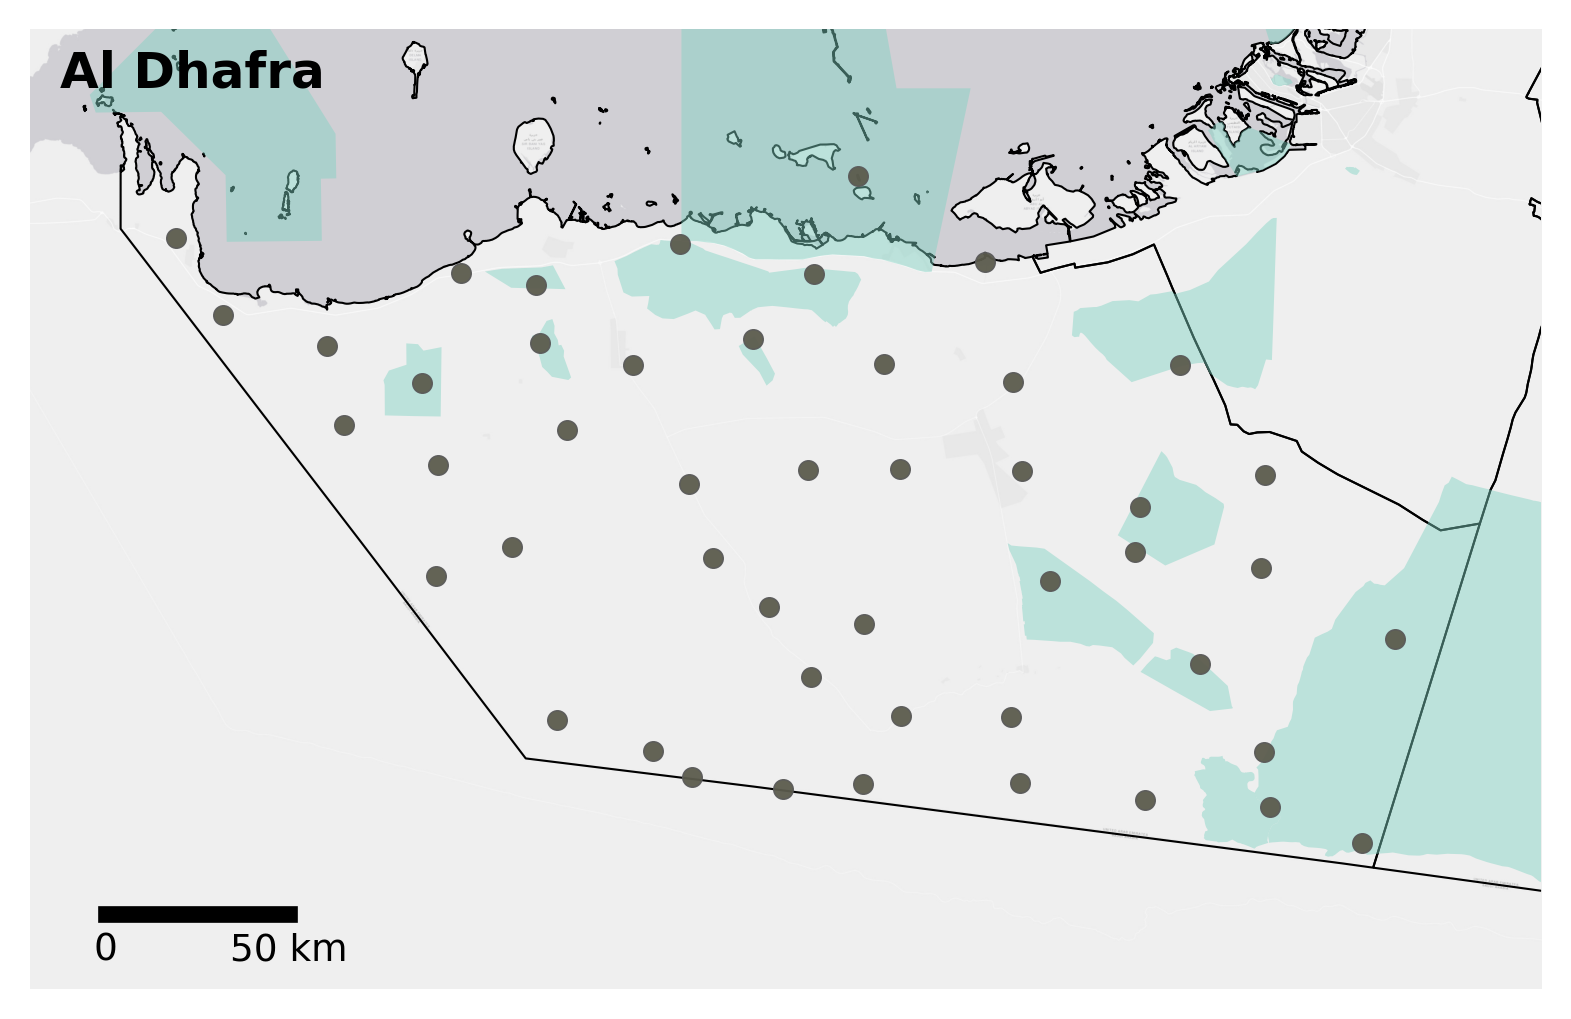

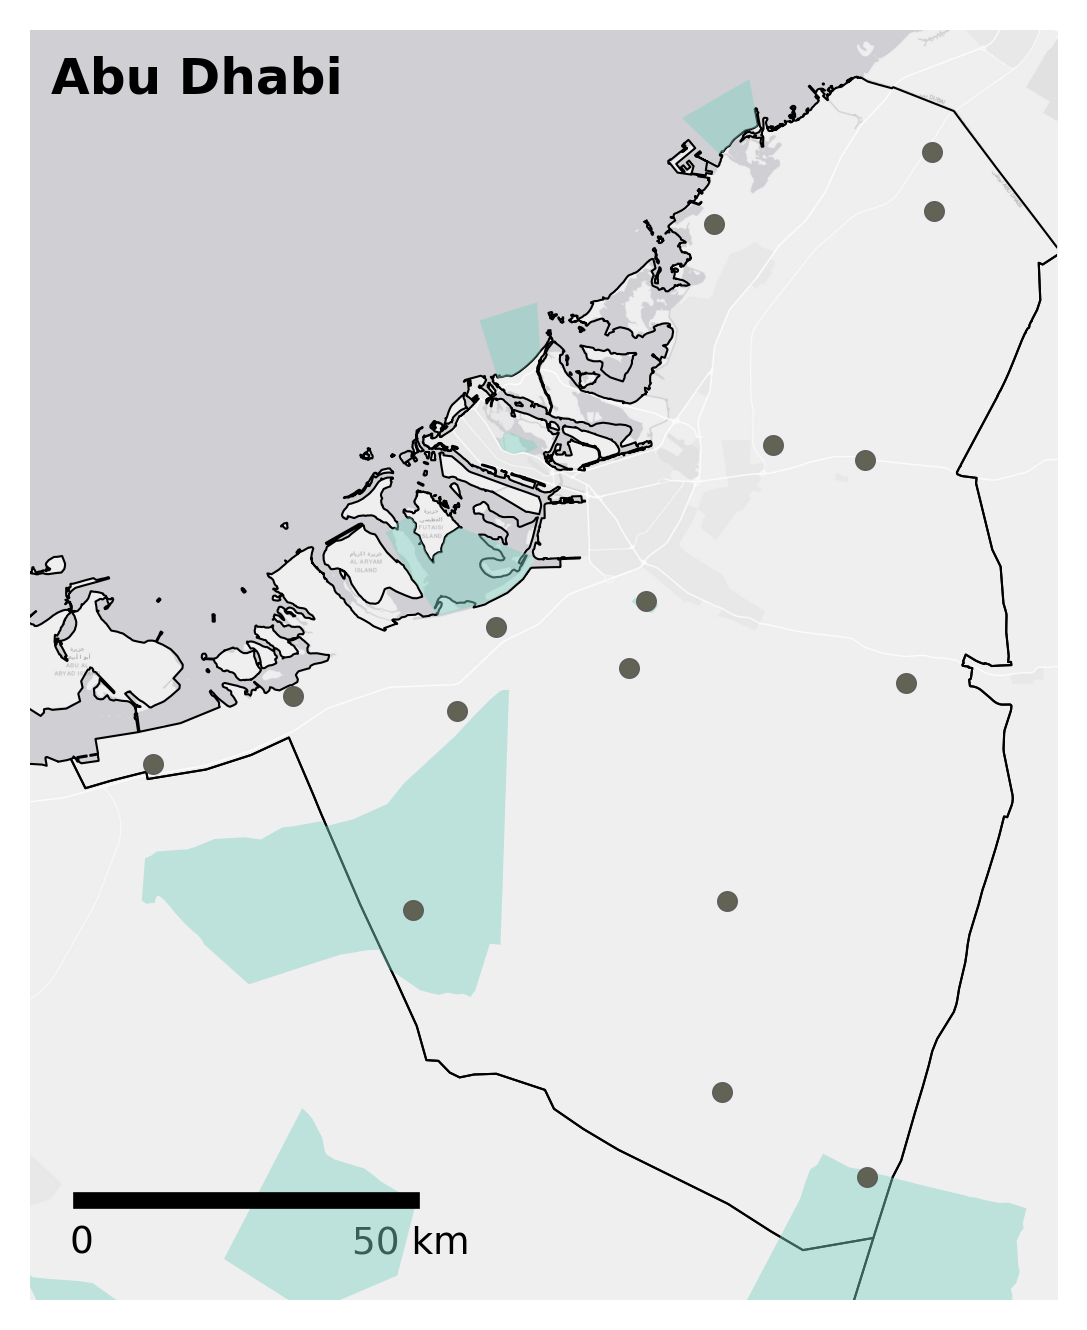

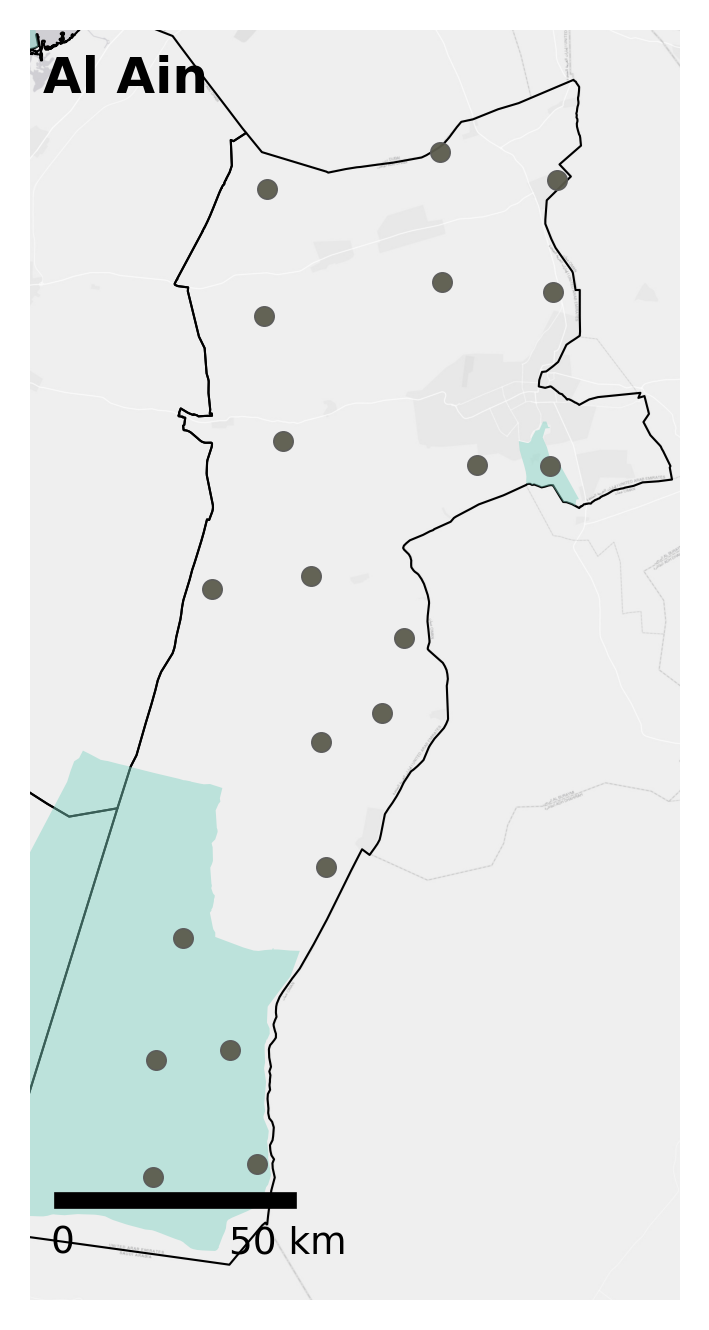

In [14]:
# =================================================
# 2) REGION MAPS (3 separate figures)
# =================================================
for label, bbox, pts_in in region_aoi:
    bxmin, bymin, bxmax, bymax = bbox
    ypad_local = 0.03 * (bymax - bymin)

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    ax.set_xlim(bxmin, bxmax)
    ax.set_ylim(bymin, bymax)

    cx.add_basemap(ax, source=BASEMAP, zoom=11, attribution=False)

    regions.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, zorder=5)
    protected.plot(
    ax=ax,
    facecolor="#7FD3C3",
    edgecolor="none",
    alpha=0.45,
    zorder=6
)

    ax.scatter(
        pts_in.geometry.x, pts_in.geometry.y,
        s=22, c=IND_COLOR,
        edgecolors="#5a5a5a",
        linewidths=0.35,
        alpha=0.95,
        zorder=10
    )

    # 左上角 region 标签（你明确要求）
    ax.text(
        0.02, 0.98, label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12, weight="bold",
        color="black",
        zorder=50
    )

    ax.set_axis_off()
    # add_north_arrow(ax)
    add_scale_bar(ax, bxmin, bymin + ypad_local, bxmax, bymax, length_km=50)

    # 保存/显示
    # fig.savefig(os.path.join(OUT_DIR, f"Industrial_{label.replace(' ', '_')}.png"), dpi=300, bbox_inches="tight")
    plt.show()
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_NonDeveloped_{label.replace(' ', '_')}.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch04_NonDeveloped_{label.replace(' ', '_')}.svg"), bbox_inches="tight", pad_inches=0.1)

# all

[INFO] Industrial sites: 169
[INFO] Al Ain: pts=33 raw_bbox_km_w=97.9 raw_bbox_km_h=67.5
[INFO] Al Dhafra: pts=25 raw_bbox_km_w=272.8 raw_bbox_km_h=112.4
[INFO] Abu Dhabi: pts=111 raw_bbox_km_w=74.9 raw_bbox_km_h=80.8


C:\Users\blkmo\AppData\Local\Temp\ipykernel_2876\1837277404.py:166: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_2876\1837277404.py:166: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
C:\Users\blkmo\AppData\Local\Temp\ipykernel_2876\1837277404.py:166: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()


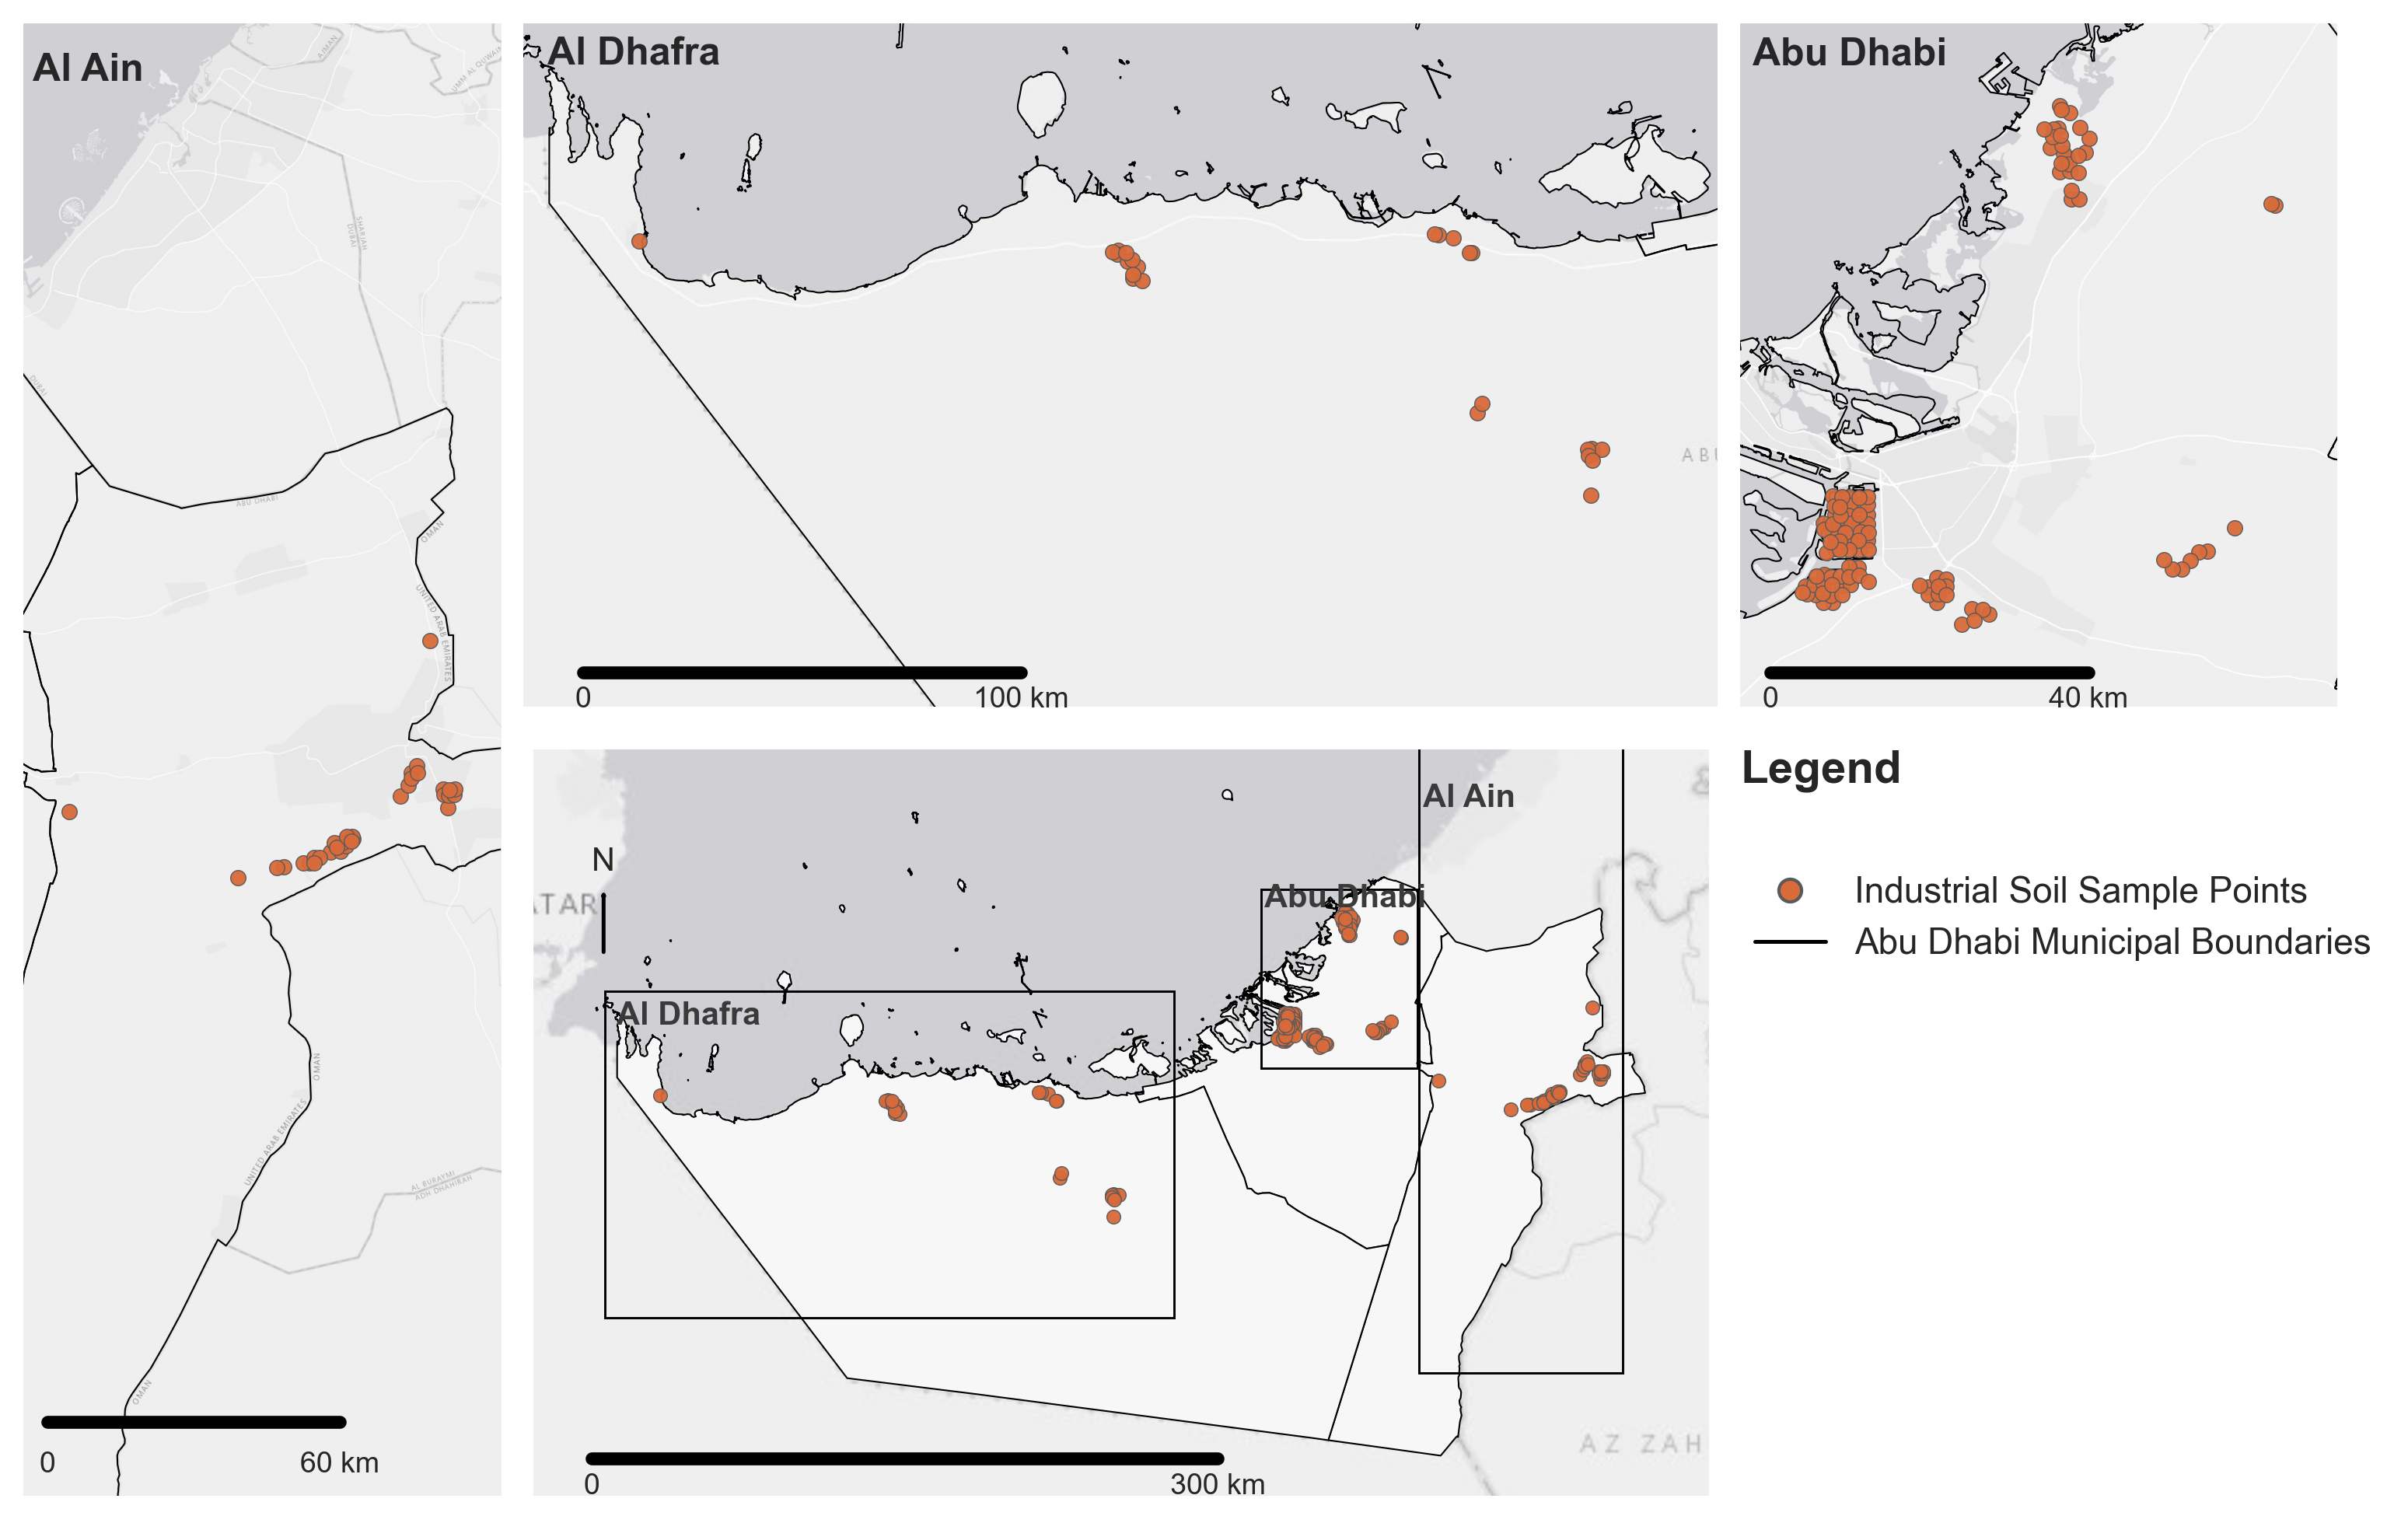

[DONE] ../Result_hmq/Ch04_Figures\Ch04_Industrial_layout_fixed_ratio.png


In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib as mpl

from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.lines import Line2D

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300


# ============================================================
# Map decorations
# ============================================================
def add_north_arrow(ax, x=0.05, y=0.86, dy=0.07):
    arrow = FancyArrowPatch(
        (x, y), (x, y + dy),
        transform=ax.transAxes,
        arrowstyle="-|>",
        linewidth=1.2,
        color="black",
        zorder=30
    )
    ax.add_patch(arrow)
    ax.text(
        x, y + dy + 0.01, "N",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10, zorder=30
    )

def add_scale_bar(ax, xmin, ymin, xmax, ymax, length_km=200):
    length_m = length_km * 1000
    x0 = xmin + 0.05 * (xmax - xmin)
    y0 = ymin + 0.05 * (ymax - ymin)

    ax.plot([x0, x0 + length_m], [y0, y0],
            color="black", linewidth=4, zorder=30)

    ax.text(x0, y0 - 0.02 * (ymax - ymin), "0",
            ha="center", va="top", fontsize=9)

    ax.text(x0 + length_m, y0 - 0.02 * (ymax - ymin),
            f"{length_km} km",
            ha="center", va="top", fontsize=9)


# ============================================================
# Key: expand bbox to match axes aspect ratio (keep equal scale)
# ============================================================
def bbox_fit_axes(raw_bbox, ax, extra_pad=0.0):
    """
    Expand raw_bbox to match ax aspect ratio (width/height), keeping map scale equal.
    Only expands (never shrinks). Keeps center fixed.
    CRS must be projected (EPSG:3857 is OK).
    """
    xmin, ymin, xmax, ymax = raw_bbox
    xr, yr = (xmax - xmin), (ymax - ymin)
    if xr <= 0 or yr <= 0:
        return raw_bbox

    bb = ax.get_window_extent()
    ax_ratio = bb.width / bb.height  # width/height in display pixels

    data_ratio = xr / yr
    cx0, cy0 = (xmin + xmax) / 2, (ymin + ymax) / 2

    if data_ratio < ax_ratio:
        # bbox is too tall -> expand X
        new_xr = ax_ratio * yr
        xmin = cx0 - new_xr / 2
        xmax = cx0 + new_xr / 2
    else:
        # bbox is too wide -> expand Y
        new_yr = xr / ax_ratio
        ymin = cy0 - new_yr / 2
        ymax = cy0 + new_yr / 2

    if extra_pad > 0:
        xmin -= extra_pad; xmax += extra_pad
        ymin -= extra_pad; ymax += extra_pad

    return (xmin, ymin, xmax, ymax)


# ============================================================
# Config
# ============================================================
EXCEL_PATH = r"../Soil quality data/Soil quality data 2025.xlsx"
SHEET_NAME = "PHChemical"
ABU_DHABI_SHP = r"../data_hmq/Map/abu_dhabi.shp"

BASEMAP = cx.providers.Esri.WorldGrayCanvas

OUT_DIR = r"../Result_hmq/Ch04_Figures"
os.makedirs(OUT_DIR, exist_ok=True)

IND_COLOR = "#D96A3A"
SURVEY_ID = 9  # Industrial

REGION_KEYWORDS = [
    ("Al Ain",    ["Ain"]),
    ("Al Dhafra", ["Dhafra"]),
    ("Abu Dhabi", ["Abu Dhabi"]),
]

PAD_MIN_M = 5000
PAD_RATIO = 0.12

# ========= Layout ratio control (you can tune) =========
W_LEFT, W_MID, W_RIGHT = 0.4, 1, 0.5
H_TOP, H_BOTTOM = 0.55, 0.6
WS, HS = 0.03, 0.06
# =======================================================


# ============================================================
# Read data
# ============================================================
data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

# Find a region-name field
candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = next((f for f in candidate_fields if f in regions.columns), None)
if name_field is None:
    raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

# Industrial points (dedup by SiteUID)
sub = data[data["SurveyID"] == SURVEY_ID].copy()
sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID"])
sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

gdf = gpd.GeoDataFrame(
    sub,
    geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
    crs="EPSG:4326",
).to_crs(3857)

print("[INFO] Industrial sites:", len(gdf))

# Match 3 regions in shapefile
regions_3 = []
for label, keys in REGION_KEYWORDS:
    mask = np.zeros(len(regions), dtype=bool)
    for k in keys:
        mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
    reg = regions[mask].copy()
    if len(reg) == 0:
        print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
    regions_3.append((label, reg))


# ============================================================
# Build raw bboxes (points-inside-region)
# ============================================================
raw_aoi = {}  # label -> dict(raw_bbox, pts_in)
for label, reg_poly in regions_3:
    if len(reg_poly) == 0:
        continue

    pts_in = gdf[gdf.within(reg_poly.unary_union)].copy()
    if len(pts_in) == 0:
        print(f"[WARN] No Industrial points inside region '{label}'.")
        continue

    xmin, ymin, xmax, ymax = pts_in.total_bounds
    w = xmax - xmin
    h = ymax - ymin
    pad = max(PAD_MIN_M, PAD_RATIO * max(w, h))

    raw_bbox = (xmin - pad, ymin - pad, xmax + pad, ymax + pad)
    raw_aoi[label] = {"raw_bbox": raw_bbox, "pts": pts_in}
    print(f"[INFO] {label}: pts={len(pts_in)} raw_bbox_km_w={(raw_bbox[2]-raw_bbox[0])/1000:.1f} raw_bbox_km_h={(raw_bbox[3]-raw_bbox[1])/1000:.1f}")


# ============================================================
# Create figure & axes (layout)
# ============================================================
fig = plt.figure(figsize=(12.8, 8.2))

gs = fig.add_gridspec(
    nrows=2, ncols=3,
    width_ratios=[W_LEFT, W_MID, W_RIGHT],
    height_ratios=[H_TOP, H_BOTTOM],
    wspace=WS, hspace=HS
)

ax_alain  = fig.add_subplot(gs[:, 0])  # span 2 rows
ax_dhafra = fig.add_subplot(gs[0, 1])
ax_abudh  = fig.add_subplot(gs[0, 2])
ax_full   = fig.add_subplot(gs[1, 1])
ax_leg    = fig.add_subplot(gs[1, 2])

# IMPORTANT: draw once so axes sizes are known (for bbox_fit_axes)
fig.canvas.draw()


# ============================================================
# Convert raw_bbox -> display_bbox (match each axis aspect)
# ============================================================
disp_aoi = {}  # label -> dict(display_bbox, pts)
if "Al Ain" in raw_aoi:
    disp_aoi["Al Ain"] = {
        "bbox": bbox_fit_axes(raw_aoi["Al Ain"]["raw_bbox"], ax_alain),
        "pts": raw_aoi["Al Ain"]["pts"],
    }
if "Al Dhafra" in raw_aoi:
    disp_aoi["Al Dhafra"] = {
        "bbox": bbox_fit_axes(raw_aoi["Al Dhafra"]["raw_bbox"], ax_dhafra),
        "pts": raw_aoi["Al Dhafra"]["pts"],
    }
if "Abu Dhabi" in raw_aoi:
    disp_aoi["Abu Dhabi"] = {
        "bbox": bbox_fit_axes(raw_aoi["Abu Dhabi"]["raw_bbox"], ax_abudh),
        "pts": raw_aoi["Abu Dhabi"]["pts"],
    }


# ============================================================
# Draw helpers
# ============================================================
def draw_region(ax, *, bbox, pts, label, zoom, scale_km):
    bxmin, bymin, bxmax, bymax = bbox
    ax.set_xlim(bxmin, bxmax)
    ax.set_ylim(bymin, bymax)

    cx.add_basemap(ax, source=BASEMAP, zoom=zoom, attribution=False)

    # This may set aspect='equal' internally; we keep it (no distortion)
    regions.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, zorder=5)

    ax.scatter(
        pts.geometry.x, pts.geometry.y,
        s=22, c=IND_COLOR,
        edgecolors="#5a5a5a",
        linewidths=0.35,
        alpha=0.95,
        zorder=10
    )

    ax.text(0.02, 0.98, label, transform=ax.transAxes,
            ha="left", va="top", fontsize=12, weight="bold", zorder=50)

    ax.set_axis_off()
    add_scale_bar(ax, bxmin, bymin, bxmax, bymax, length_km=scale_km)


def draw_full(ax, *, zoom=7, scale_km=300):
    xmin, ymin, xmax, ymax = regions.total_bounds
    xpad = 0.06 * (xmax - xmin)
    ypad = 0.06 * (ymax - ymin)

    ax.set_xlim(xmin - xpad, xmax + xpad)
    ax.set_ylim(ymin - ypad, ymax + ypad)

    cx.add_basemap(ax, source=BASEMAP, zoom=zoom, attribution=False)
    regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=0.5, zorder=5)

    ax.scatter(
        gdf.geometry.x, gdf.geometry.y,
        s=18, c=IND_COLOR,
        edgecolors="#5a5a5a",
        linewidths=0.35,
        alpha=0.95,
        zorder=10
    )

    # AOI rectangles: use display bboxes (match the region panels)
    for label, info in disp_aoi.items():
        bxmin, bymin, bxmax, bymax = info["bbox"]
        ax.add_patch(Rectangle(
            (bxmin, bymin), bxmax - bxmin, bymax - bymin,
            fill=False, edgecolor="black", linewidth=0.7, zorder=20
        ))
        # optional label inside box
        ax.text(bxmin + 0.02*(bxmax-bxmin), bymax - 0.10*(bymax-bymin),
                label, fontsize=10, weight="bold", color="#3a3a3a", zorder=21)

    ax.set_axis_off()
    add_north_arrow(ax, x=0.06, y=0.72, dy=0.10)
    add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=scale_km)


def draw_legend(ax):
    ax.set_axis_off()
    ax.text(0.0, 1.0, "Legend",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=14, weight="bold")

    handles = [
        Line2D([0], [0], marker='o', color='none',
               markerfacecolor=IND_COLOR, markeredgecolor="#5a5a5a",
               markersize=7, label="Industrial Soil Sample Points"),
        Line2D([0], [0], color="black", linewidth=1.2,
               label="Abu Dhabi Municipal Boundaries"),
    ]
    ax.legend(handles=handles, loc="upper left",
              frameon=False, bbox_to_anchor=(0.0, 0.85),
              borderaxespad=0.0, fontsize=11)


# ============================================================
# Draw panels
# ============================================================
# You can tune zoom/scale per panel to match your example feel
if "Al Ain" in disp_aoi:
    draw_region(ax_alain, bbox=disp_aoi["Al Ain"]["bbox"], pts=disp_aoi["Al Ain"]["pts"],
                label="Al Ain", zoom=10, scale_km=60)
else:
    ax_alain.set_axis_off()

if "Al Dhafra" in disp_aoi:
    draw_region(ax_dhafra, bbox=disp_aoi["Al Dhafra"]["bbox"], pts=disp_aoi["Al Dhafra"]["pts"],
                label="Al Dhafra", zoom=9, scale_km=100)
else:
    ax_dhafra.set_axis_off()

if "Abu Dhabi" in disp_aoi:
    draw_region(ax_abudh, bbox=disp_aoi["Abu Dhabi"]["bbox"], pts=disp_aoi["Abu Dhabi"]["pts"],
                label="Abu Dhabi", zoom=11, scale_km=40)
else:
    ax_abudh.set_axis_off()

draw_full(ax_full, zoom=7, scale_km=300)
draw_legend(ax_leg)


# ============================================================
# Save
# ============================================================
out_png = os.path.join(OUT_DIR, "Ch04_Industrial_layout_fixed_ratio.png")
out_svg = os.path.join(OUT_DIR, "Ch04_Industrial_layout_fixed_ratio.svg")

# fig.savefig(out_png, dpi=300, bbox_inches="tight", pad_inches=0.06)
# fig.savefig(out_svg, bbox_inches="tight", pad_inches=0.06)
plt.show()

print("[DONE]", out_png)
